In [13]:
from importlib import reload
from itertools import chain

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from evaluation import evaluator

reload(evaluator)

<module 'evaluation.evaluator' from '/home/alex/code/ML/ML24/exercise-1/evaluation/evaluator.py'>

# Preprocessing

In [2]:
data = arff.loadarff('./datasets/credit-g/dataset_31_credit-g.arff')
data = pd.DataFrame(data[0])

for column in data.columns:
    # replace missing values with pd.NA
    data[column] = data[column].replace(b'?', pd.NA)
    data[column] = data[column].replace(b'', pd.NA)
    data[column] = data[column].replace(b'NONE', pd.NA)
    # decode bytes to string for each column
    data[column] = data[column].apply(lambda x: x.decode() if isinstance(x, bytes) else x)

In [3]:
data

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12.0,existing paid,furniture/equipment,1736.0,<100,4<=X<7,3.0,female div/dep/mar,none,...,real estate,31.0,none,own,1.0,unskilled resident,1.0,none,yes,good
996,<0,30.0,existing paid,used car,3857.0,<100,1<=X<4,4.0,male div/sep,none,...,life insurance,40.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes,good
997,no checking,12.0,existing paid,radio/tv,804.0,<100,>=7,4.0,male single,none,...,car,38.0,none,own,1.0,skilled,1.0,none,yes,good
998,<0,45.0,existing paid,radio/tv,1845.0,<100,1<=X<4,4.0,male single,none,...,no known property,23.0,none,for free,1.0,skilled,1.0,yes,yes,bad


In [4]:
y = data[('class')] 
X = data.drop('class', axis=1)  # Features


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
print("null values in train data: "+ str(X_train.isnull().sum().sum()))
print("null values in test data: "+ str(X_test.isnull().sum().sum()))

null values in train data: 0
null values in test data: 0


In [6]:
# find all numerical columns in X_train
numerical_columns = X_train.select_dtypes(include="number").columns
# convert numerical columns to list
numerical_columns = numerical_columns.tolist()
numerical_columns

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents']

In [7]:
feature_mappings = {
    'checking_status': ['no checking', '<0', '0<=X<200', '>=200'],
    'saving_status': ['no known savings', '<100', '100<=X<500', '500<=X<1000', '>=1000'],
    'employment': ['unemployed', '<1', '1<=X<4', '4<=X<7', '>=7'],
    'own_telephone': ['none', 'yes'],
    'foreign_worker': ['no', 'yes'],
}

ordinal_columns = [col for col in X_train.columns if col in feature_mappings.keys()]
ordinal_categories = [feature_mappings[col] for col in ordinal_columns]
ordinal_columns

['checking_status', 'employment', 'own_telephone', 'foreign_worker']

In [8]:
categorical_columns = [col for col in X_train.columns if col not in ordinal_columns and col not in numerical_columns] 

one_hot_encoding_limit = 10
one_hot_columns = [col for col in categorical_columns if X_train[col].nunique() <= one_hot_encoding_limit]

label_columns = [col for col in categorical_columns if col not in one_hot_columns]

In [9]:
preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_columns),
    ('categorical', OneHotEncoder(handle_unknown="ignore"), one_hot_columns),
    ('label', OrdinalEncoder(), label_columns)
],
    remainder='passthrough'  # passthrough columns not listed in any pipeline
)

In [10]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler())
])

pipeline_standard = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])

X_train_std = pipeline.fit_transform(X_train)
X_test_std = pipeline.transform(X_test)

# Preprocess training data
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [11]:
# Encode target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Evaluation

## Neural Network

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'hidden_layer_sizes': 7, 'max_iter': 1500, 'verbose': False}
done with  learning_rate_init   1e-06
done with  learning_rate_init   1.4030037231905748e-06
done with  learning_rate_init   1.9684194472866114e-06
done with  learning_rate_init   2.761699813343849e-06
done with  learning_rate_init   3.874675120456128e-06
done with  learning_rate_init   5.436183620153837e-06


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   7.626985859023451e-06
done with  learning_rate_init   1.0700689556931746e-05
done with  learning_rate_init   1.5013107289081743e-05
done with  learning_rate_init   2.10634454232412e-05


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   2.9552092352028878e-05
done with  learning_rate_init   4.146169559796814e-05
done with  learning_rate_init   5.817091329374358e-05
done with  learning_rate_init   8.161400793251835e-05
done with  learning_rate_init   0.00011450475699382824
done with  learning_rate_init   0.00016065060038537288
done with  learning_rate_init   0.00022539339047347913


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   0.00031622776601683794


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   0.0004436687330978611


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: 

done with  learning_rate_init   0.0006224688843995446


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   0.0008733261623828437


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   0.0012252798573828651
done with  learning_rate_init   0.0017190722018585747
done with  learning_rate_init   0.002411864699640997
done with  learning_rate_init   0.003383855153428233
done with  learning_rate_init   0.004747561378997425
done with  learning_rate_init   0.006660846290809161
done with  learning_rate_init   0.009345192145605374
done with  learning_rate_init   0.013111339374215656
done with  learning_rate_init   0.01839525795803971
done with  learning_rate_init   0.025808615404180765
done with  learning_rate_init   0.03620958350245917
done with  learning_rate_init   0.05080218046913023
done with  learning_rate_init   0.07127564834438921
done with  learning_rate_init   0.1


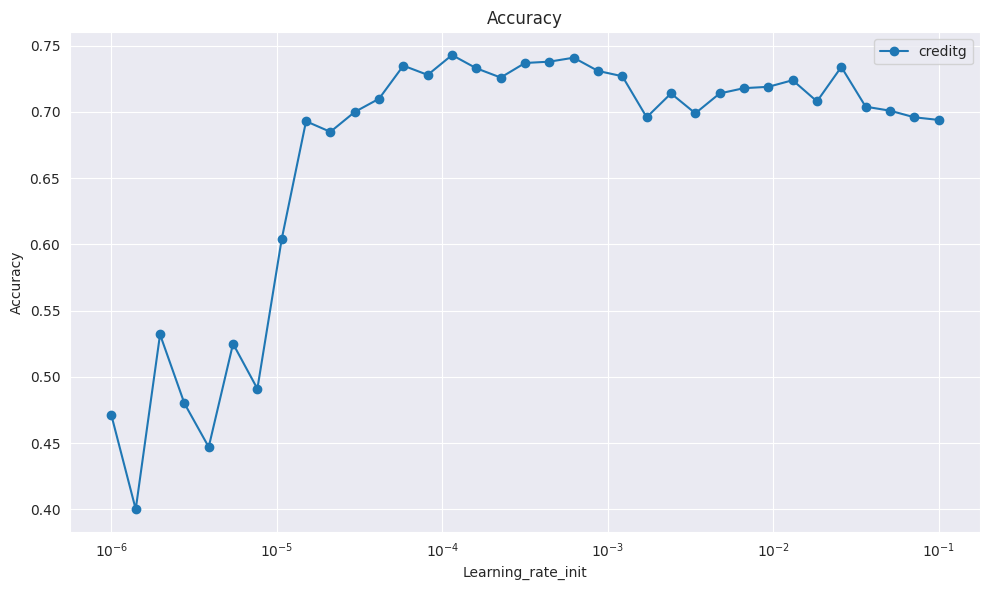

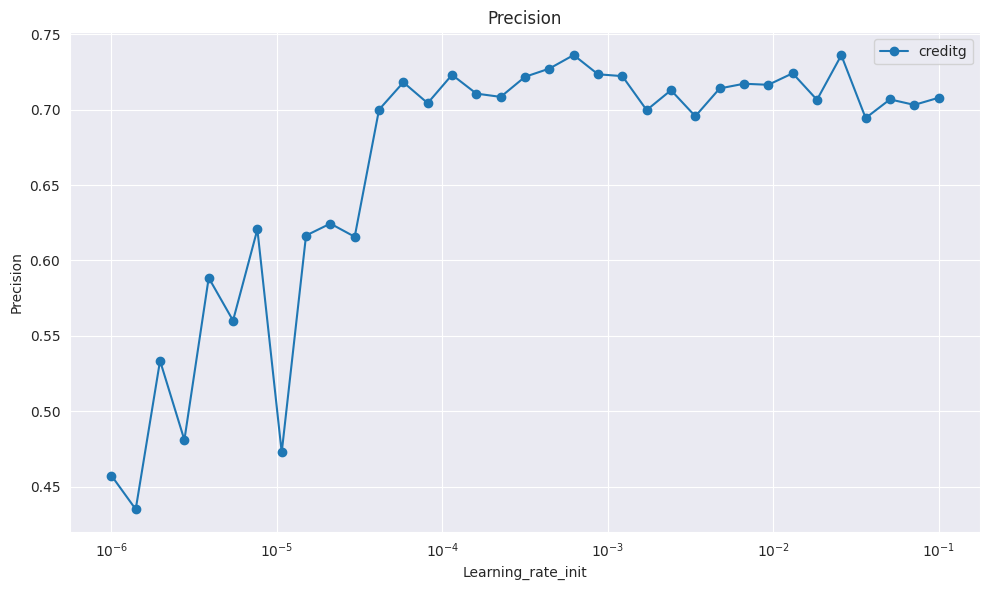

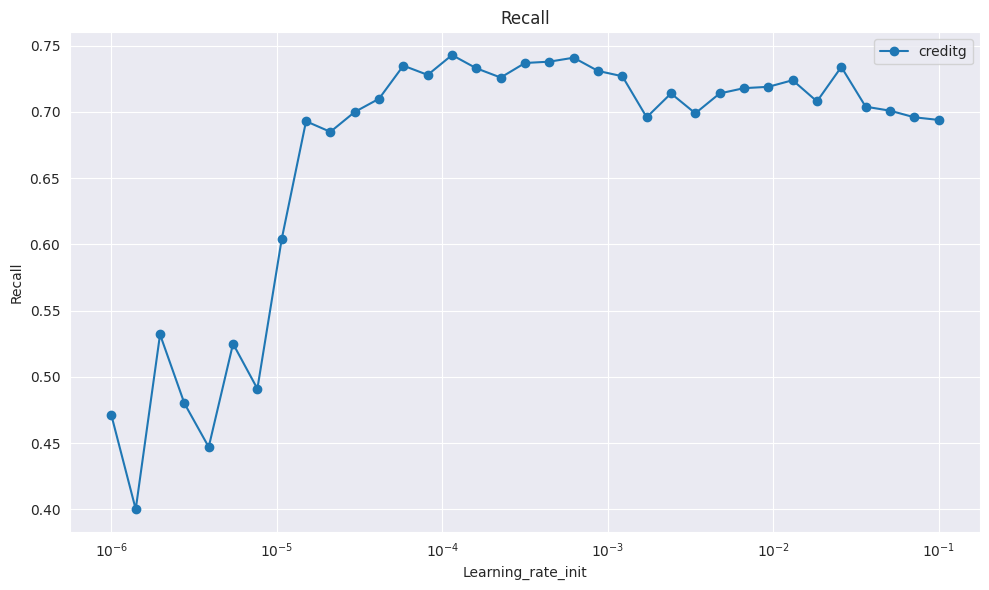

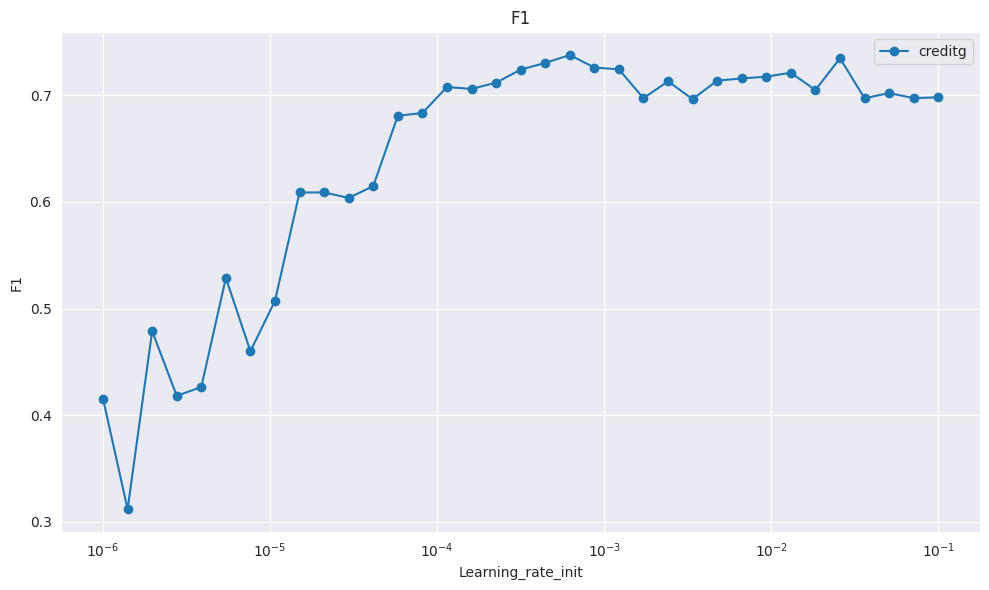

In [26]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    'hidden_layer_sizes': (7),
    #'random_state': 7895,
    'max_iter': 1500,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'learning_rate_init': np.logspace(-6, -1, num=35)}
nn_learning_rate = evaluator.evaluate2_mean(MLPClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=5)
evaluator.draw_diagram2_list({"creditg": nn_learning_rate}, x_axis='learning_rate_init', y_axis=['accuracy', 'precision', 'recall', 'f1'], logaritmic=True)

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 5000, 'verbose': False}
done with  hidden_layer_sizes   (1,)
done with  hidden_layer_sizes   (2,)
done with  hidden_layer_sizes   (3,)
done with  hidden_layer_sizes   (4,)
done with  hidden_layer_sizes   (5,)
done with  hidden_layer_sizes   (6,)
done with  hidden_layer_sizes   (7,)
done with  hidden_layer_sizes   (8,)
done with  hidden_layer_sizes   (9,)
done with  hidden_layer_sizes   (12,)
done with  hidden_layer_sizes   (14,)
done with  hidden_layer_sizes   (16,)
done with  hidden_layer_sizes   (18,)


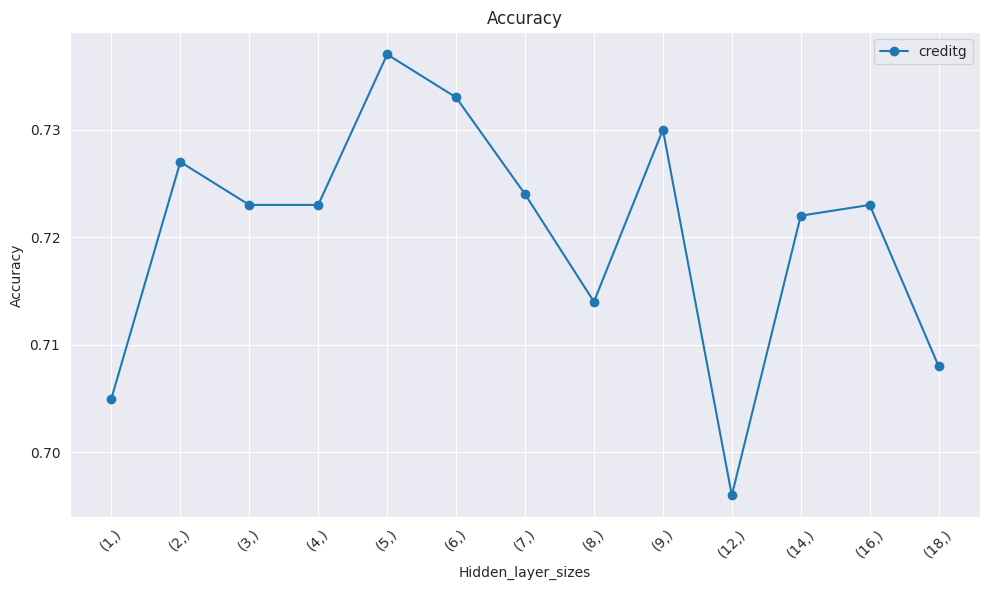

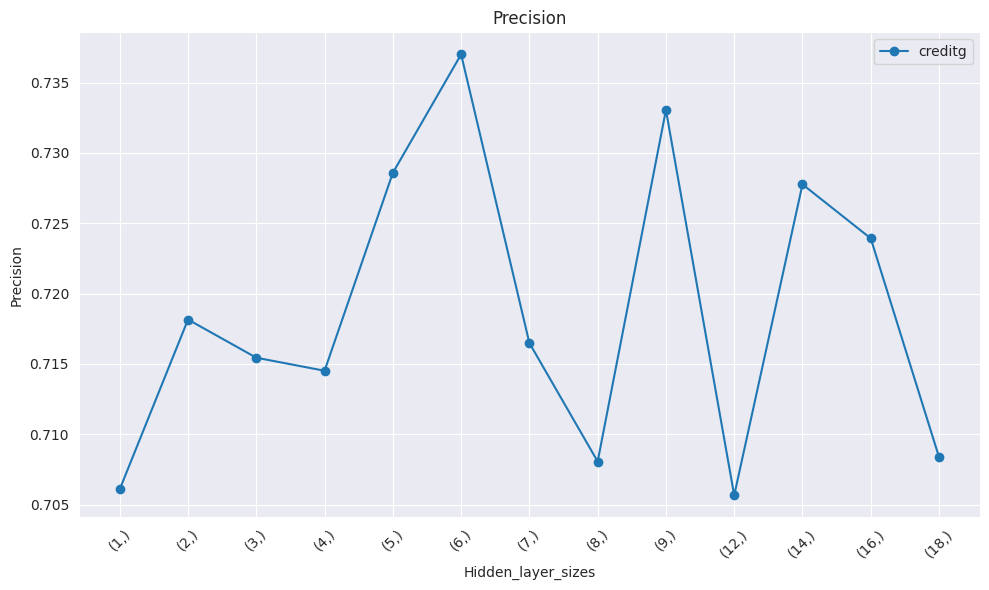

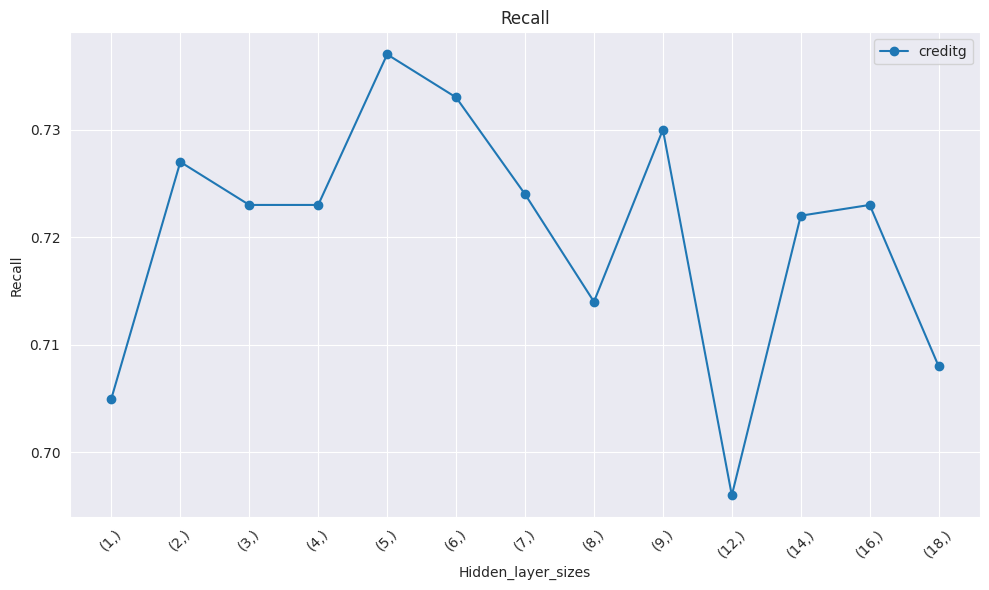

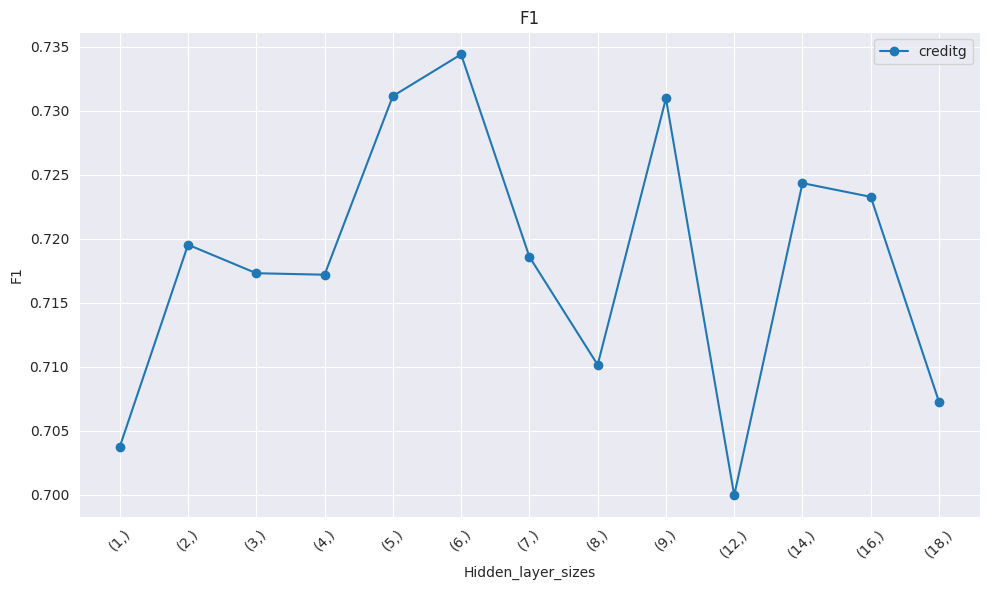

In [23]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    #'hidden_layer_sizes': (15, 15, 15),
    #'random_state': 7895,
    'max_iter': 5000,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'hidden_layer_sizes': [(i,) for i in chain(range(1, 10, 1), range(10, 20, 2))]}
nn_hidden_layer = evaluator.evaluate2_mean(MLPClassifier, X_train_std, y_train, X_test_std, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=5)
evaluator.draw_diagram2_list({"creditg": nn_hidden_layer}, x_axis='hidden_layer_sizes', y_axis=['accuracy', 'precision', 'recall', 'f1'], logaritmic=False)

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 5000, 'verbose': False}
done with  hidden_layer_sizes   (7,)
done with  hidden_layer_sizes   (7, 7)
done with  hidden_layer_sizes   (7, 7, 7)
done with  hidden_layer_sizes   (7, 7, 7, 7)


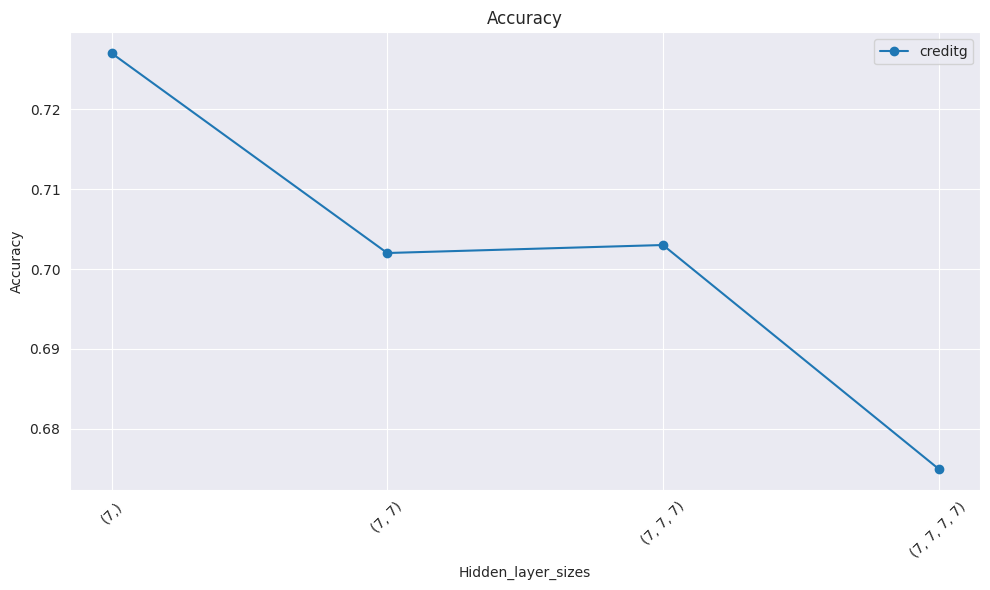

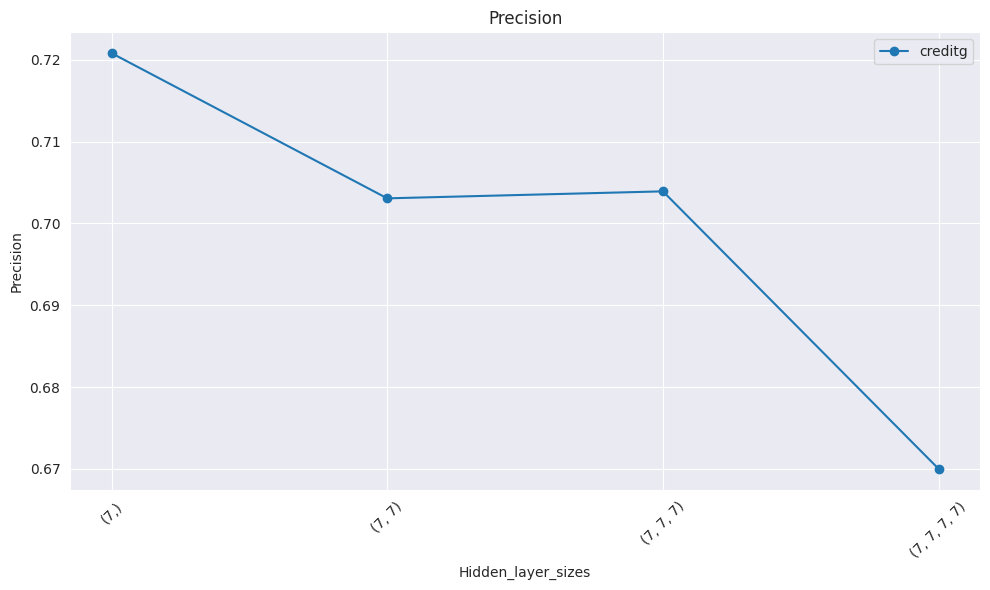

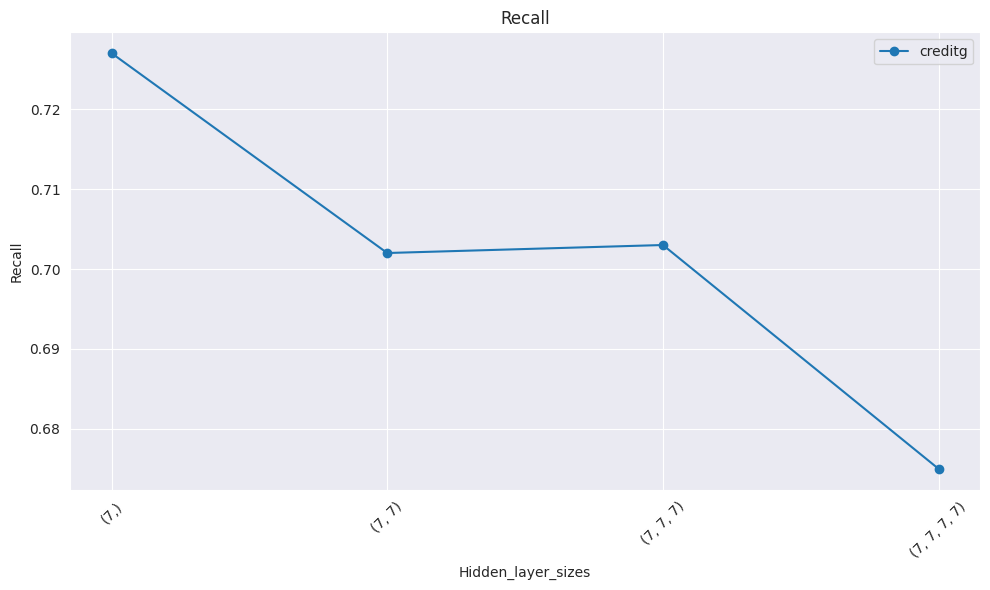

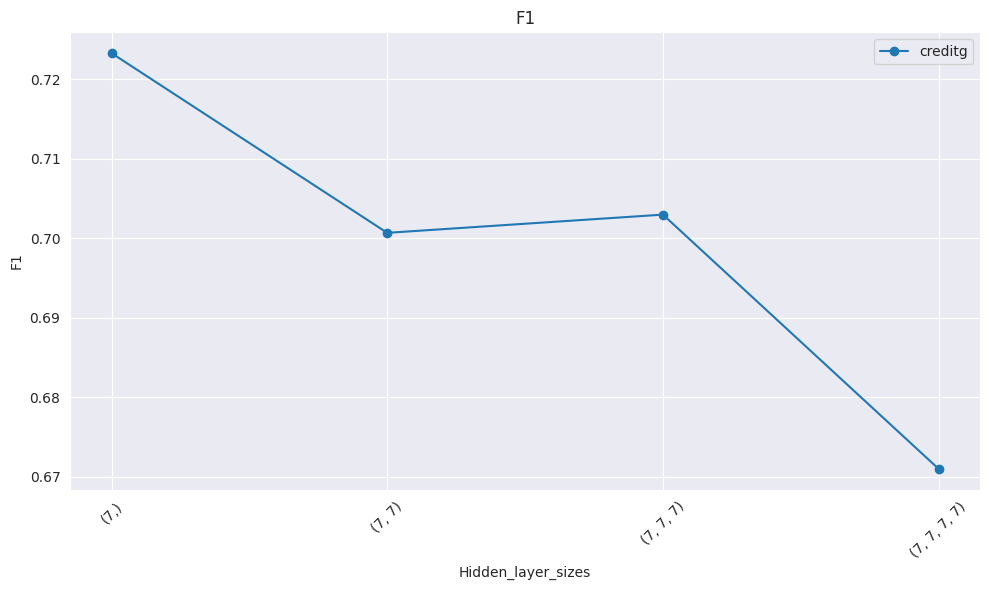

In [22]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    #'hidden_layer_sizes': (15, 15, 15),
    #'random_state': 7895,
    'max_iter': 5000,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'hidden_layer_sizes': [(7, ), (7, 7), (7, 7, 7), (7, 7, 7, 7),]}
nn_hidden_layer_deepness = evaluator.evaluate2_mean(MLPClassifier, X_train_std, y_train, X_test_std, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=5)
evaluator.draw_diagram2_list({"creditg": nn_hidden_layer_deepness}, x_axis='hidden_layer_sizes', y_axis=['accuracy', 'precision', 'recall', 'f1'], logaritmic=False)

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (15, 15, 15), 'verbose': False}
Hyperparameter  max_iter  value:  50
Accuracy:  0.725
Recall:  0.725
Precision:  0.70421875
F1:  0.7072905131044667
Time: 58.224678ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  22 |  37 |
|  1 |  18 | 123 |
+----+-----+-----+
Hyperparameter  max_iter  value:  60
Accuracy:  0.725
Recall:  0.725
Precision:  0.7096767363071712
F1:  0.7140355125100888
Time: 66.099882ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  25 |  34 |
|  1 |  21 | 120 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  70
Accuracy:  0.725
Recall:  0.725
Precision:  0.716177234927235
F1:  0.7196592786558185
Time: 77.982187ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  24 | 117 |
+----+-----+-----+
Hyperparameter  max_iter  value:  80
Accuracy:  0.695
Recall:  0.695
Precision:  0.6876877219685439
F1:  0.6909090068144675
Time: 88.693142ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  28 | 113 |
+----+-----+-----+
Hyperparameter  max_iter  value:  90
Accuracy:  0.76
Recall:  0.76
Precision:  0.7555862068965518
F1:  0.7574677953625323
Time: 97.386837ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  33 |  26 |
|  1 |  22 | 119 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stoch

Hyperparameter  max_iter  value:  100
Accuracy:  0.7
Recall:  0.7
Precision:  0.683479349186483
F1:  0.6891413169041202
Time: 107.660055ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  23 |  36 |
|  1 |  24 | 117 |
+----+-----+-----+
Hyperparameter  max_iter  value:  110
Accuracy:  0.71
Recall:  0.71
Precision:  0.7044576802507837
F1:  0.7069402527297264
Time: 118.506432ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  27 | 114 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (130) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  120
Accuracy:  0.685
Recall:  0.685
Precision:  0.6773959918822932
F1:  0.6807748758903519
Time: 132.372141ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  25 |  34 |
|  1 |  29 | 112 |
+----+-----+-----+
Hyperparameter  max_iter  value:  130
Accuracy:  0.765
Recall:  0.765
Precision:  0.7597298325722983
F1:  0.7618479232832783
Time: 143.682003ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  33 |  26 |
|  1 |  21 | 120 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (140) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  140
Accuracy:  0.715
Recall:  0.715
Precision:  0.7164166666666668
F1:  0.7156903615538742
Time: 156.662464ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  29 | 112 |
+----+-----+-----+
Hyperparameter  max_iter  value:  150
Accuracy:  0.73
Recall:  0.73
Precision:  0.73
F1:  0.73
Time: 162.061214ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  32 |  27 |
|  1 |  27 | 114 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (160) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (170) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  160
Accuracy:  0.685
Recall:  0.685
Precision:  0.6865595238095239
F1:  0.6857630311911241
Time: 178.534269ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  32 | 109 |
+----+-----+-----+
Hyperparameter  max_iter  value:  170
Accuracy:  0.715
Recall:  0.715
Precision:  0.7193232819074333
F1:  0.7170007997867235
Time: 188.512564ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  32 |  27 |
|  1 |  30 | 111 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (180) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  180
Accuracy:  0.675
Recall:  0.675
Precision:  0.6734033511413307
F1:  0.6741853160581076
Time: 192.103863ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  32 | 109 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (190) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  190
Accuracy:  0.735
Recall:  0.735
Precision:  0.7449016282225237
F1:  0.7390472727272727
Time: 205.767870ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  36 |  23 |
|  1 |  30 | 111 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  200
Accuracy:  0.715
Recall:  0.715
Precision:  0.7223299632352942
F1:  0.7182204807607643
Time: 215.501070ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  33 |  26 |
|  1 |  31 | 110 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (210) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  210
Accuracy:  0.75
Recall:  0.75
Precision:  0.7476076555023924
F1:  0.7487251092763478
Time: 225.370884ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  33 |  26 |
|  1 |  24 | 117 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (220) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  220
Accuracy:  0.71
Recall:  0.71
Precision:  0.7018136311128225
F1:  0.7052529761904762
Time: 245.313644ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  27 |  32 |
|  1 |  26 | 115 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (230) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  230
Accuracy:  0.66
Recall:  0.66
Precision:  0.680779561087455
F1:  0.668136752136752
Time: 242.999792ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  40 | 101 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (240) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  240
Accuracy:  0.685
Recall:  0.685
Precision:  0.6804017857142857
F1:  0.6825491990846682
Time: 257.365942ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  30 | 111 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  250
Accuracy:  0.675
Recall:  0.675
Precision:  0.6798562412342215
F1:  0.6772816137918778
Time: 266.427040ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  34 | 107 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (260) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  260
Accuracy:  0.72
Recall:  0.72
Precision:  0.72
F1:  0.72
Time: 277.819395ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  28 | 113 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (270) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  270
Accuracy:  0.725
Recall:  0.725
Precision:  0.716177234927235
F1:  0.7196592786558185
Time: 291.505814ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  24 | 117 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (280) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  280
Accuracy:  0.72
Recall:  0.72
Precision:  0.7146833855799373
F1:  0.7170457612562876
Time: 304.521799ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  26 | 115 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (290) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  290
Accuracy:  0.725
Recall:  0.725
Precision:  0.7210565476190476
F1:  0.7228604118993135
Time: 311.431646ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  30 |  29 |
|  1 |  26 | 115 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  300
Accuracy:  0.735
Recall:  0.735
Precision:  0.7419163602941177
F1:  0.737994482110886
Time: 319.780350ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  35 |  24 |
|  1 |  29 | 112 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (310) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  310
Accuracy:  0.69
Recall:  0.69
Precision:  0.69
F1:  0.69
Time: 328.645468ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  31 | 110 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (320) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  320
Accuracy:  0.65
Recall:  0.65
Precision:  0.6785866666666668
F1:  0.660369206598586
Time: 342.025995ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  32 |  27 |
|  1 |  43 |  98 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (330) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  330
Accuracy:  0.7
Recall:  0.7
Precision:  0.7
F1:  0.7
Time: 356.965065ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  30 | 111 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (340) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  340
Accuracy:  0.77
Recall:  0.77
Precision:  0.7678186725555146
F1:  0.76882710053424
Time: 359.197855ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  35 |  24 |
|  1 |  22 | 119 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  350
Accuracy:  0.725
Recall:  0.725
Precision:  0.7522389643463498
F1:  0.7334940600978337
Time: 371.235847ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  40 |  19 |
|  1 |  36 | 105 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (360) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  360
Accuracy:  0.745
Recall:  0.745
Precision:  0.7517095588235294
F1:  0.7478814827859469
Time: 388.063192ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  36 |  23 |
|  1 |  28 | 113 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (370) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  370
Accuracy:  0.68
Recall:  0.68
Precision:  0.68
F1:  0.68
Time: 390.038490ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  27 |  32 |
|  1 |  32 | 109 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (380) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  380
Accuracy:  0.695
Recall:  0.695
Precision:  0.7092981283422459
F1:  0.7007796140867008
Time: 406.009436ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  33 |  26 |
|  1 |  35 | 106 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (390) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  390
Accuracy:  0.7
Recall:  0.7
Precision:  0.6860791998918774
F1:  0.691248097412481
Time: 422.737360ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  24 |  35 |
|  1 |  25 | 116 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  400
Accuracy:  0.68
Recall:  0.68
Precision:  0.6617104714226116
F1:  0.6684174046977281
Time: 432.090044ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  21 |  38 |
|  1 |  26 | 115 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (410) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  410
Accuracy:  0.67
Recall:  0.67
Precision:  0.6540113528855251
F1:  0.6603729071537291
Time: 446.879625ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  21 |  38 |
|  1 |  28 | 113 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (420) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  420
Accuracy:  0.69
Recall:  0.69
Precision:  0.6994700854700855
F1:  0.6941304347826087
Time: 447.837114ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  34 | 107 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (430) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  430
Accuracy:  0.68
Recall:  0.68
Precision:  0.6768690958164644
F1:  0.6783681398737251
Time: 579.901457ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  31 | 110 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (440) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  440
Accuracy:  0.72
Recall:  0.72
Precision:  0.7419868406860101
F1:  0.7275350520126639
Time: 811.686993ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  38 |  21 |
|  1 |  35 | 106 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (450) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  450
Accuracy:  0.685
Recall:  0.685
Precision:  0.6897230014025246
F1:  0.6872114102905891
Time: 473.327160ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  33 | 108 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (460) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  460
Accuracy:  0.68
Recall:  0.68
Precision:  0.68
F1:  0.68
Time: 481.947422ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  27 |  32 |
|  1 |  32 | 109 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (470) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  470
Accuracy:  0.755
Recall:  0.755
Precision:  0.7705329670329669
F1:  0.7604734117108614
Time: 503.377199ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  40 |  19 |
|  1 |  30 | 111 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (480) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  480
Accuracy:  0.7
Recall:  0.7
Precision:  0.6970801128695865
F1:  0.6984701311316173
Time: 511.930704ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  29 | 112 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (490) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  490
Accuracy:  0.71
Recall:  0.71
Precision:  0.7189914529914531
F1:  0.7138639551192145
Time: 521.576643ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  33 |  26 |
|  1 |  32 | 109 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  500
Accuracy:  0.735
Recall:  0.735
Precision:  0.7363214285714287
F1:  0.735641915129041
Time: 526.987076ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  33 |  26 |
|  1 |  27 | 114 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (510) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  510
Accuracy:  0.7
Recall:  0.7
Precision:  0.6914516750096265
F1:  0.6950892857142857
Time: 542.098761ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  27 | 114 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (520) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  520
Accuracy:  0.715
Recall:  0.715
Precision:  0.7136073336571152
F1:  0.714285584850956
Time: 556.966305ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  30 |  29 |
|  1 |  28 | 113 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (530) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  530
Accuracy:  0.725
Recall:  0.725
Precision:  0.7236583292860612
F1:  0.7243106520491679
Time: 591.814995ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  27 | 114 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (540) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  540
Accuracy:  0.68
Recall:  0.68
Precision:  0.6965062506914482
F1:  0.6866176470588234
Time: 613.227367ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  32 |  27 |
|  1 |  37 | 104 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (550) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  550
Accuracy:  0.675
Recall:  0.675
Precision:  0.6671042617960427
F1:  0.6706407449662359
Time: 601.791143ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  24 |  35 |
|  1 |  30 | 111 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (560) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  560
Accuracy:  0.67
Recall:  0.6700000000000002
Precision:  0.6868492089832947
F1:  0.6768244485294117
Time: 627.046108ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  38 | 103 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (570) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  570
Accuracy:  0.69
Recall:  0.69
Precision:  0.7168800000000001
F1:  0.6991841544158904
Time: 666.127205ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  36 |  23 |
|  1 |  39 | 102 |
+----+-----+-----+
Hyperparameter  max_iter  value:  580
Accuracy:  0.66
Recall:  0.66
Precision:  0.6771921672751411
F1:  0.66703125
Time: 556.190014ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  30 |  29 |
|  1 |  39 | 102 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (590) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  590
Accuracy:  0.66
Recall:  0.66
Precision:  0.6701880341880342
F1:  0.6645301542776998
Time: 645.085573ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  37 | 104 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  600
Accuracy:  0.685
Recall:  0.685
Precision:  0.6657128740824393
F1:  0.6724406779661016
Time: 643.079996ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  21 |  38 |
|  1 |  25 | 116 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (610) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  610
Accuracy:  0.72
Recall:  0.72
Precision:  0.7287521367521367
F1:  0.7237307152875175
Time: 665.140152ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  34 |  25 |
|  1 |  31 | 110 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (620) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  620
Accuracy:  0.7
Recall:  0.7
Precision:  0.7060711389178543
F1:  0.7027597594055903
Time: 661.271572ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  32 | 109 |
+----+-----+-----+
Hyperparameter  max_iter  value:  630
Accuracy:  0.665
Recall:  0.665
Precision:  0.6699894810659187
F1:  0.6673518172931662
Time: 663.101673ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  27 |  32 |
|  1 |  35 | 106 |
+----+-----+-----+
Hyperparameter  max_iter  value:  640
Accuracy:  0.725
Recall:  0.725
Precision:  0.7321231617647058
F1:  0.7281074814358252
Time: 657.716751ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  34 |  25 |
|  1 |  30 | 111 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (650) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  650
Accuracy:  0.675
Recall:  0.675
Precision:  0.6970052083333332
F1:  0.6832727943471721
Time: 695.995331ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  33 |  26 |
|  1 |  39 | 102 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (660) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  660
Accuracy:  0.695
Recall:  0.695
Precision:  0.7198230373230373
F1:  0.7036318323899637
Time: 697.048187ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  36 |  23 |
|  1 |  38 | 103 |
+----+-----+-----+
Hyperparameter  max_iter  value:  670
Accuracy:  0.665
Recall:  0.665
Precision:  0.6767853912256898
F1:  0.6701163636363635
Time: 662.938595ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  37 | 104 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (680) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  680
Accuracy:  0.71
Recall:  0.71
Precision:  0.7071856213961476
F1:  0.7085211267605636
Time: 730.366468ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  28 | 113 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (690) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  690
Accuracy:  0.7
Recall:  0.7
Precision:  0.7
F1:  0.7
Time: 733.757734ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  30 | 111 |
+----+-----+-----+
Hyperparameter  max_iter  value:  700
Accuracy:  0.61
Recall:  0.61
Precision:  0.5981940700808626
F1:  0.6036160714285714
Time: 730.669975ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  17 |  42 |
|  1 |  36 | 105 |
+----+-----+-----+
Hyperparameter  max_iter  value:  710
Accuracy:  0.705
Recall:  0.705
Precision:  0.7064642857142858
F1:  0.7057145847662909
Time: 643.955708ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  30 |  29 |
|  1 |  30 | 111 |
+----+-----+-----+
Hyperparameter  max_iter  value:  720
Accuracy:  0.69
Recall:  0.69
Precision:  0.6962426138338548
F1:  0.6928517513857767
Time: 639.256239ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+

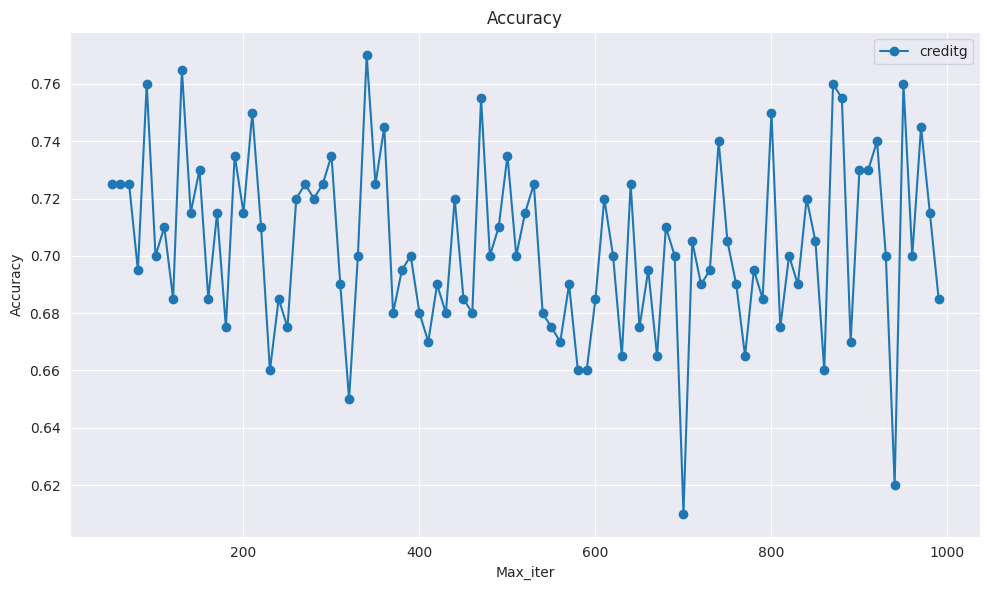

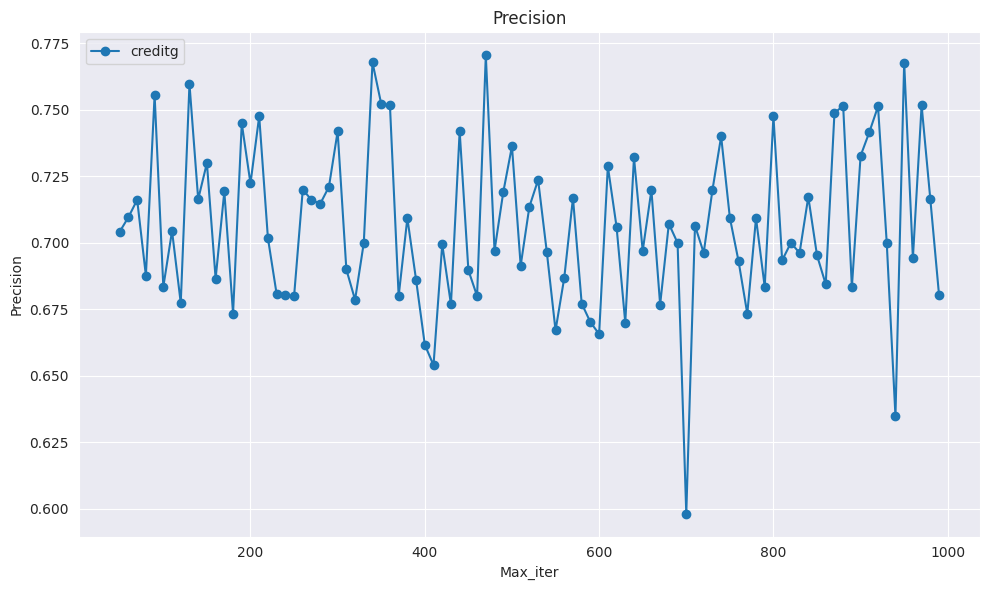

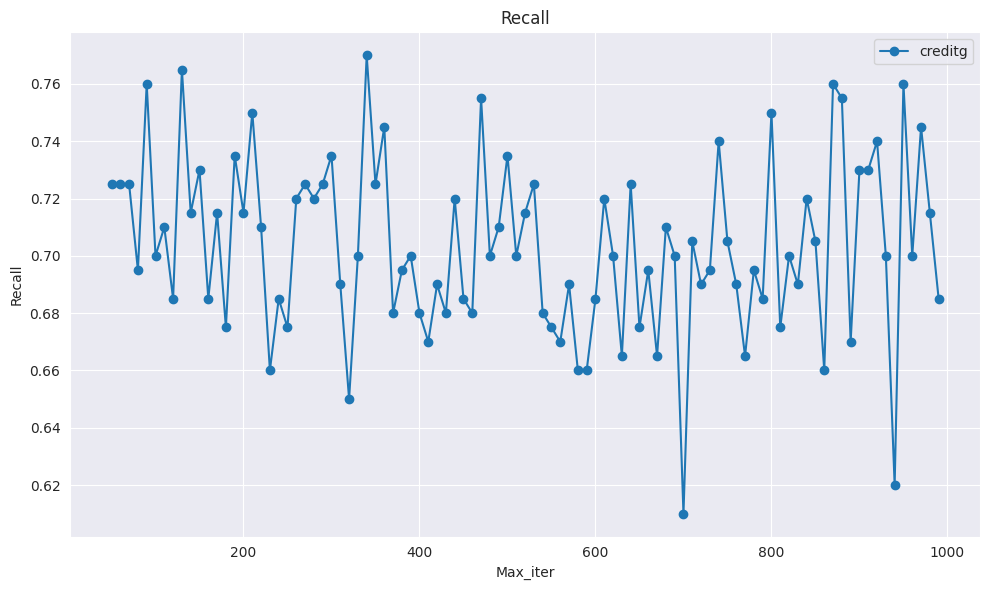

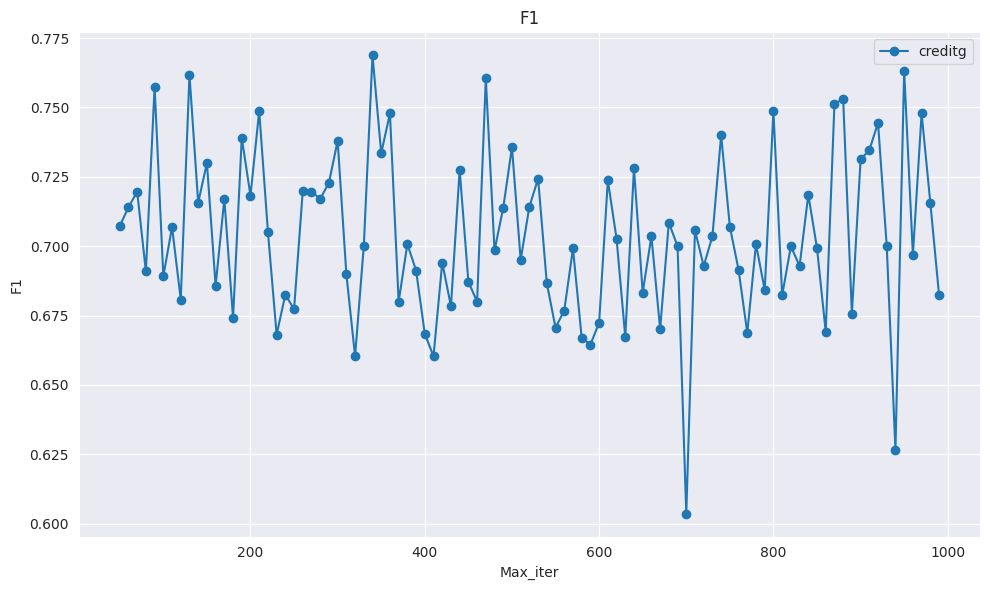

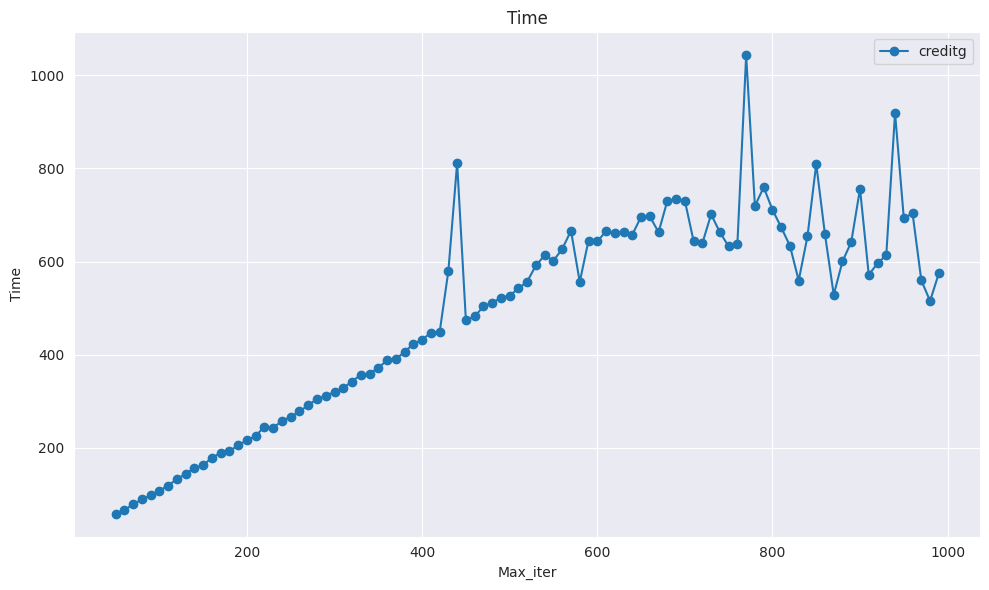

In [96]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    'learning_rate_init': 1e-3,
    'hidden_layer_sizes': (15, 15, 15),
    #'random_state': 7895,
    #'max_iter': 800,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'max_iter': range(50, 1000, 10)}
nn_max_iter = evaluator.evaluate2(MLPClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"creditg": nn_max_iter}, x_axis='max_iter', y_axis=['accuracy', 'precision', 'recall', 'f1', 'time'], logaritmic=False)

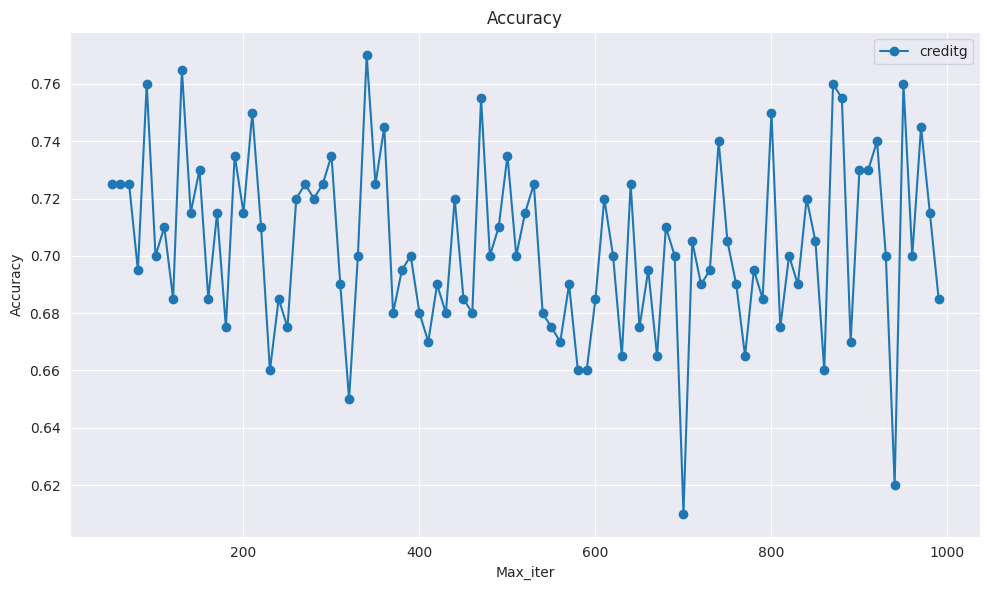

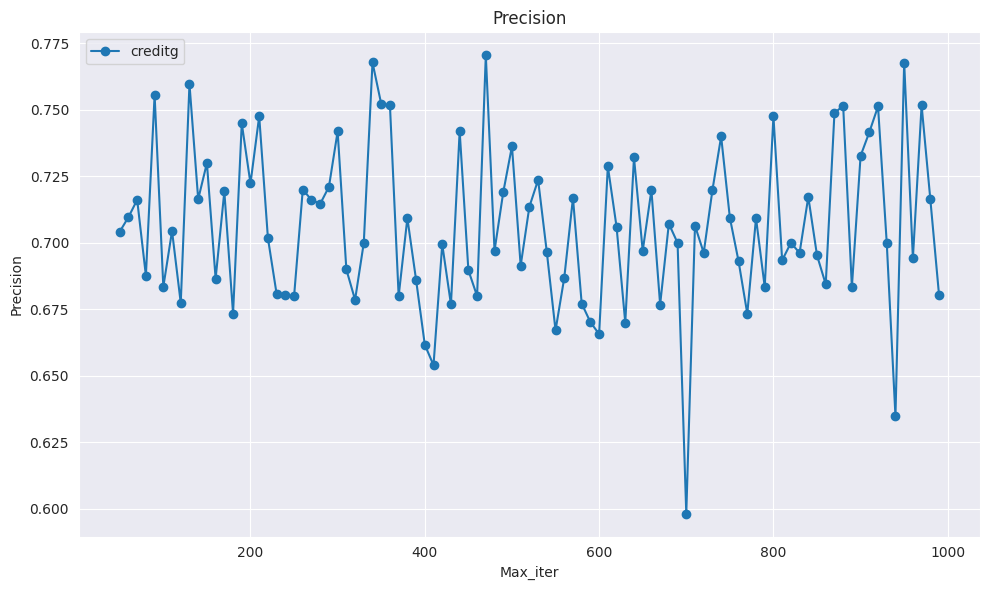

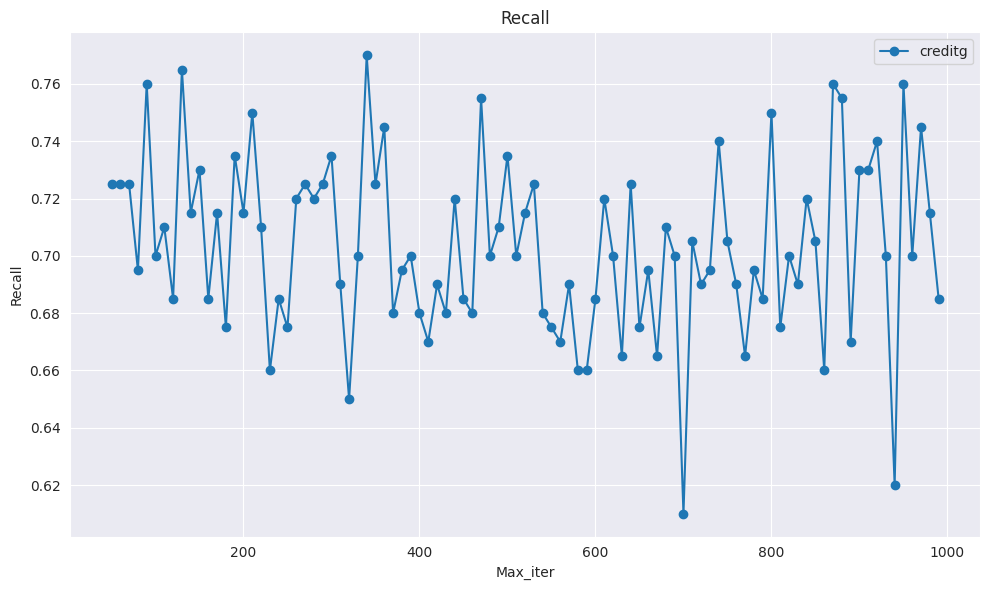

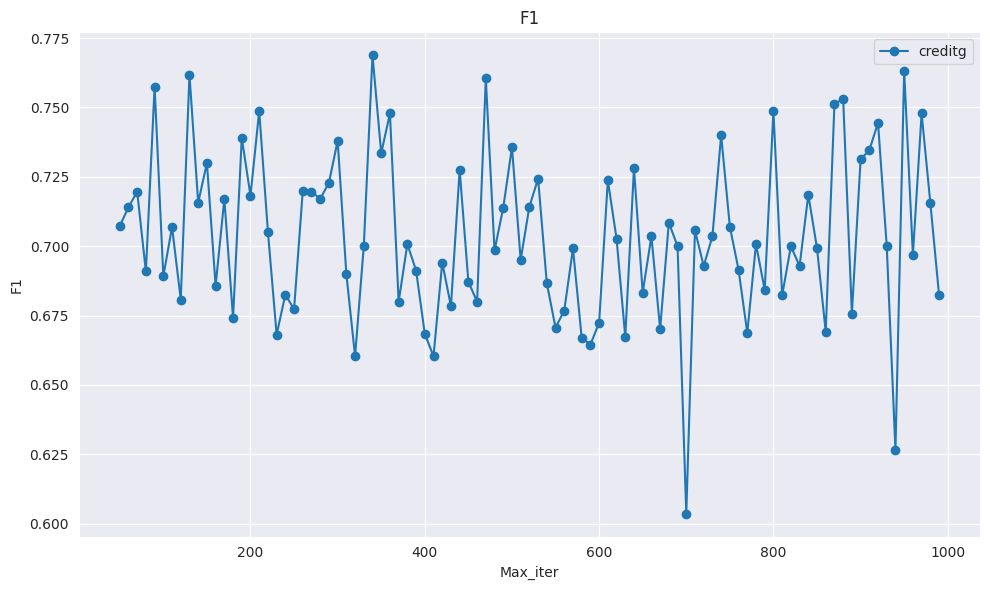

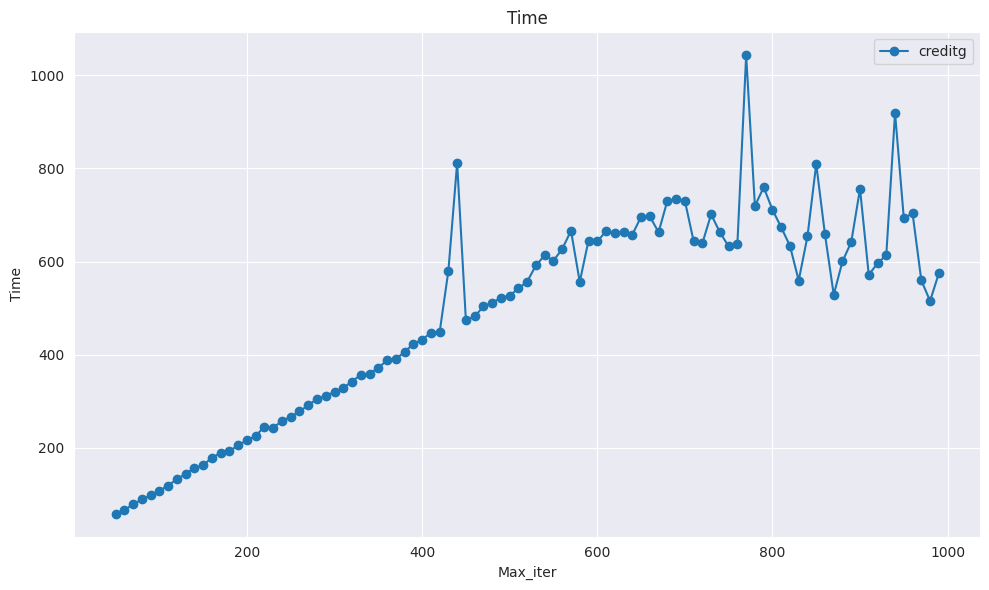

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (15, 15, 15), 'max_iter': 1000, 'verbose': False}
Hyperparameter  activation  value:  identity
Accuracy:  0.745
Recall:  0.745
Precision:  0.7316586674195371
F1:  0.7348329297820823
Time: 135.439157ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  27 |  32 |
|  1 |  19 | 122 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  activation  value:  logistic
Accuracy:  0.77
Recall:  0.77
Precision:  0.7723516924165585
F1:  0.7710952380952381
Time: 1177.265644ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  37 |  22 |
|  1 |  24 | 117 |
+----+-----+-----+
Hyperparameter  activation  value:  tanh
Accuracy:  0.7
Recall:  0.7
Precision:  0.7092307692307693
F1:  0.7039971949509116
Time: 932.360172ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  32 |  27 |
|  1 |  33 | 108 |
+----+-----+-----+
Hyperparameter  activation  value:  relu
Accuracy:  0.705
Recall:  0.705
Precision:  0.7007291666666666
F1:  0.7027048054919908
Time: 789.481163ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  28 | 113 |
+----+-----+-----+
Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (15, 1

/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  activation  value:  logistic
Accuracy:  0.76
Recall:  0.76
Precision:  0.7707013803164628
F1:  0.7641153979840111
Time: 1177.611589ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  39 |  20 |
|  1 |  28 | 113 |
+----+-----+-----+
Hyperparameter  activation  value:  tanh
Accuracy:  0.67
Recall:  0.67
Precision:  0.666763587289903
F1:  0.668317144244779
Time: 1144.594193ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  25 |  34 |
|  1 |  32 | 109 |
+----+-----+-----+
Hyperparameter  activation  value:  relu
Accuracy:  0.695
Recall:  0.695
Precision:  0.7092981283422459
F1:  0.7007796140867008
Time: 707.132101ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  33 |  26 |
|  1 |  35 | 106 |
+----+-----+-----+
Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (15, 

/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  activation  value:  logistic
Accuracy:  0.77
Recall:  0.77
Precision:  0.7723516924165585
F1:  0.7710952380952381
Time: 1134.643555ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  37 |  22 |
|  1 |  24 | 117 |
+----+-----+-----+
Hyperparameter  activation  value:  tanh
Accuracy:  0.685
Recall:  0.685
Precision:  0.7139707130730051
F1:  0.6947295597484276
Time: 923.404455ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  36 |  23 |
|  1 |  40 | 101 |
+----+-----+-----+
Hyperparameter  activation  value:  relu
Accuracy:  0.735
Recall:  0.735
Precision:  0.7363214285714287
F1:  0.735641915129041
Time: 719.020128ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  33 |  26 |
|  1 |  27 | 114 |
+----+-----+-----+


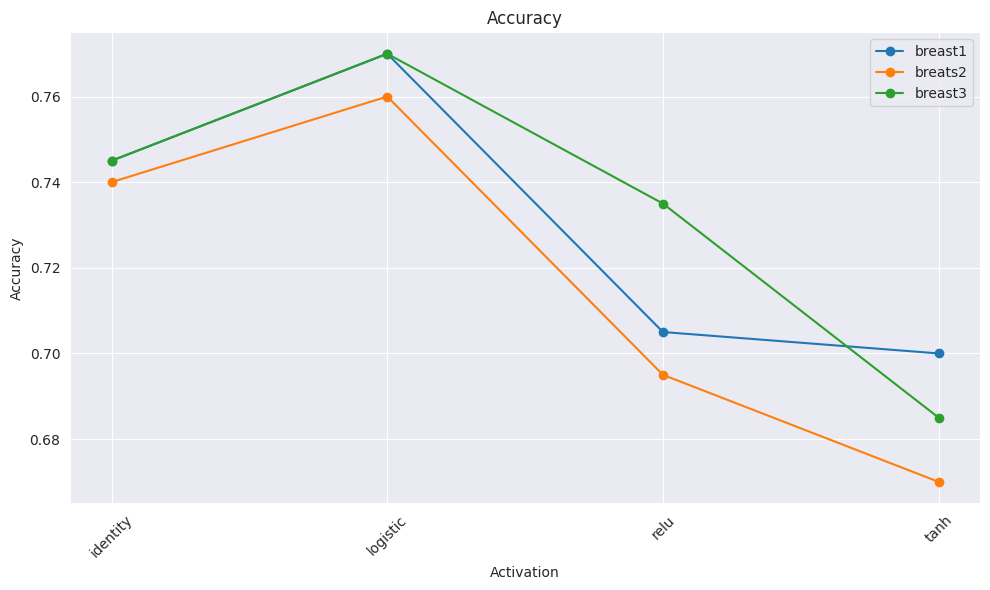

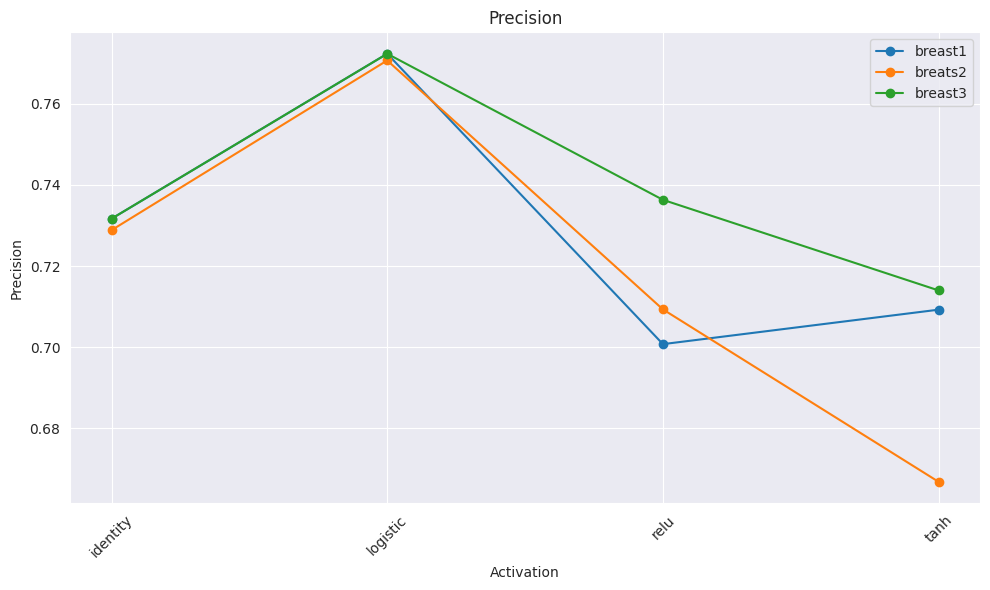

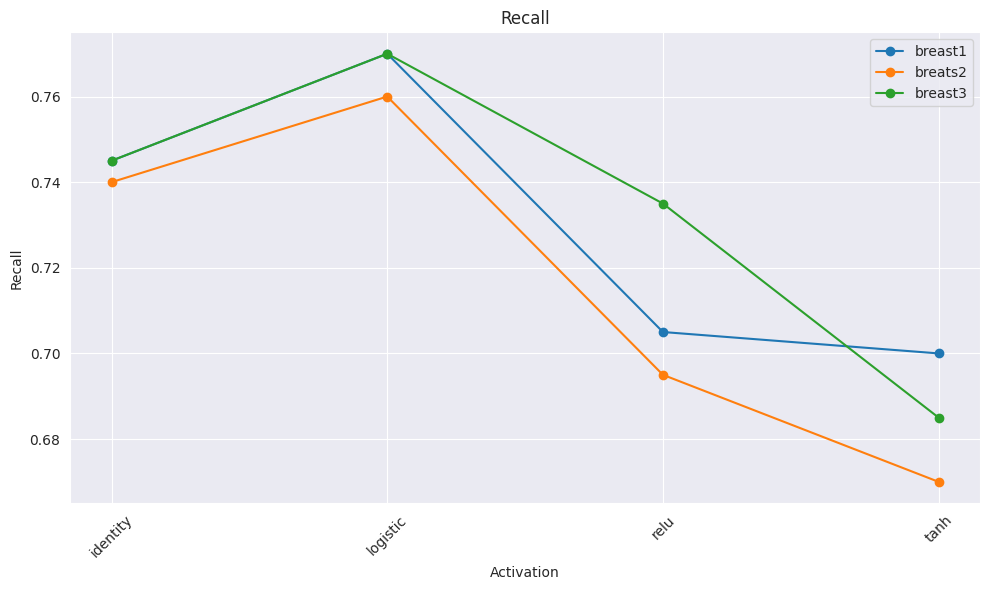

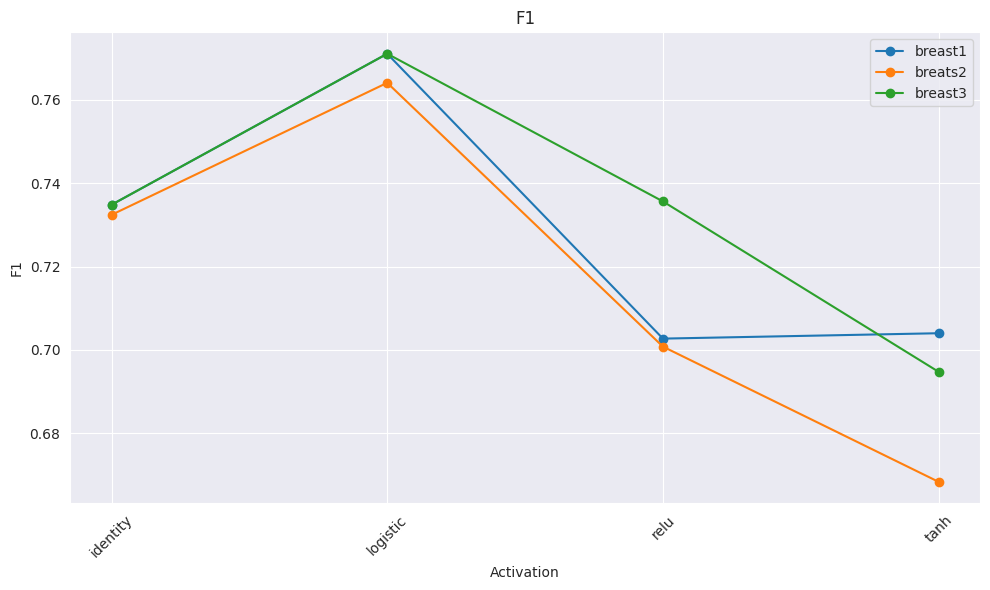

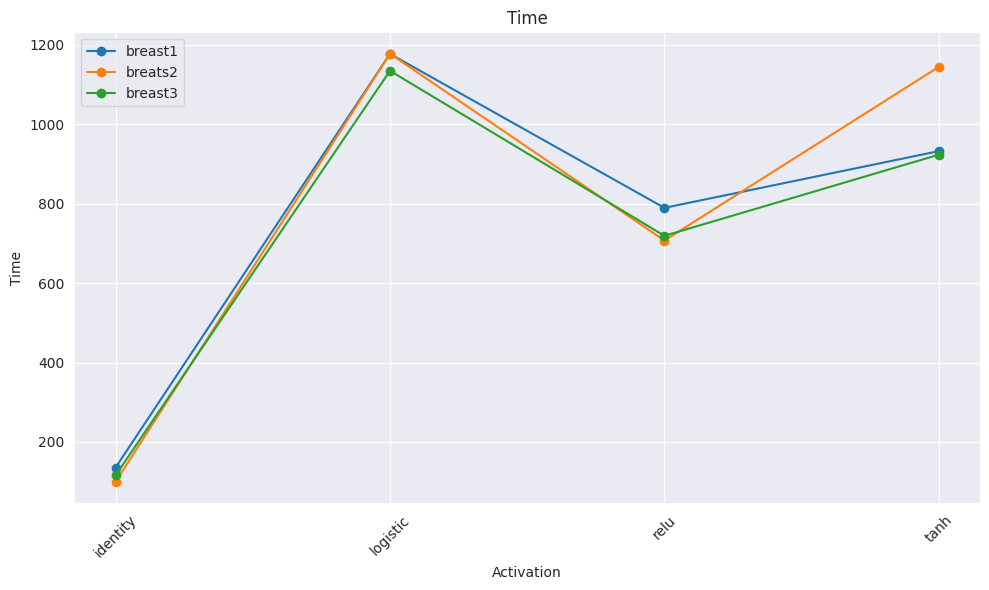

In [97]:
evaluator.draw_diagram2_list({"creditg": nn_max_iter}, x_axis='max_iter',
                             y_axis=['accuracy', 'precision', 'recall', 'f1', 'time'], logaritmic=False)
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    #'activation': 'relu',
    'learning_rate': 'constant',
    'learning_rate_init': 1e-3,
    'hidden_layer_sizes': (15, 15, 15),
    #'random_state': 7895,
    'max_iter': 1000,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'activation': ['identity', 'logistic', 'tanh', 'relu']}
act_function1 = evaluator.evaluate2(MLPClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                                    hyperparameters_iterate=hyperparameters_iterator)
act_function2 = evaluator.evaluate2(MLPClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                                    hyperparameters_iterate=hyperparameters_iterator)
act_function3 = evaluator.evaluate2(MLPClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                                    hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"breast1": act_function1, "breats2": act_function2, "breast3": act_function3},
                             x_axis='activation', y_axis=['accuracy', 'precision', 'recall', 'f1', 'time'],
                             logaritmic=False)

## Random Forest

Evaluating classifier:  RandomForestClassifier
Hyperparameters:  {'criterion': 'gini', 'verbose': False}
Hyperparameter  n_estimators  value:  1
Accuracy:  0.705
Recall:  0.705
Precision:  0.7125367647058823
F1:  0.7083334800857034
Time: 3.686666ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  32 |  27 |
|  1 |  32 | 109 |
+----+-----+-----+
Hyperparameter  n_estimators  value:  2
Accuracy:  0.675
Recall:  0.675
Precision:  0.7121875
F1:  0.686475647068552
Time: 4.550219ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  37 |  22 |
|  1 |  43 |  98 |
+----+-----+-----+
Hyperparameter  n_estimators  value:  3
Accuracy:  0.73
Recall:  0.73
Precision:  0.7181470468982295
F1:  0.7221232876712329
Time: 3.174782ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  27 |  32 |
|  1 |  22 | 119 |
+----+-----+-----+
Hyperparameter  n_estimators  value:  4
Accuracy:  0.68
Recall:  0.68
Precis

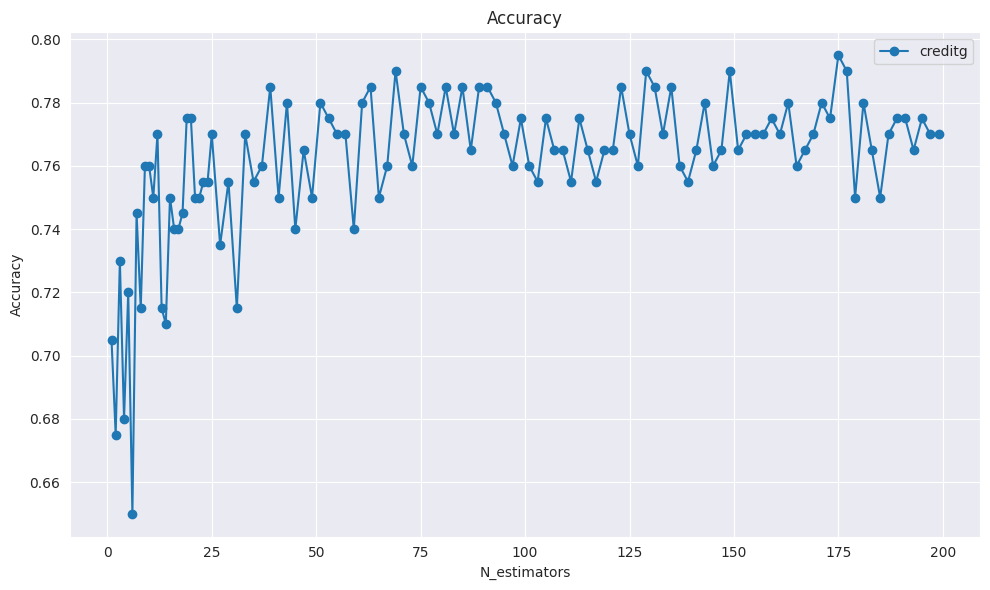

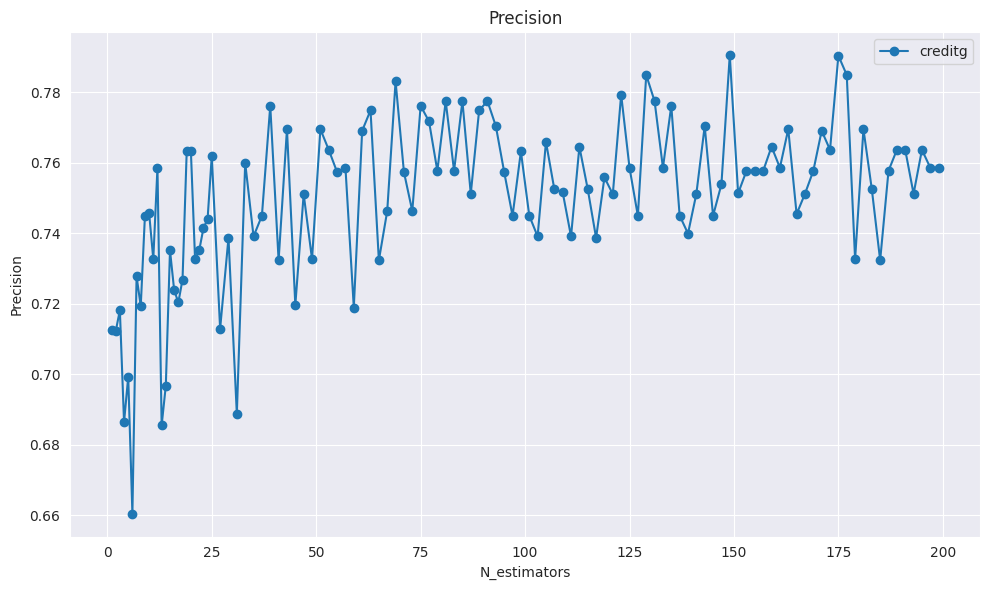

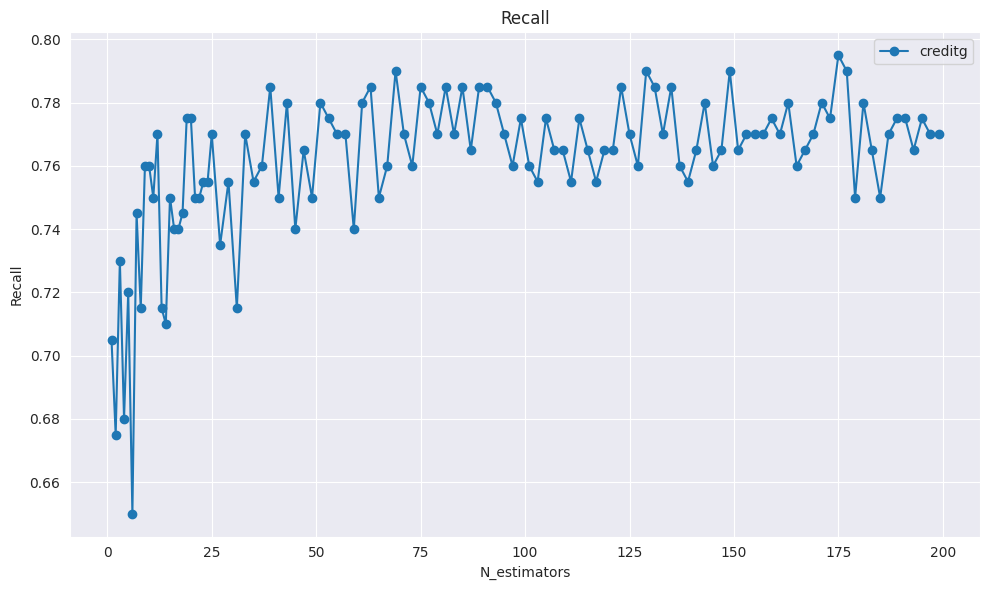

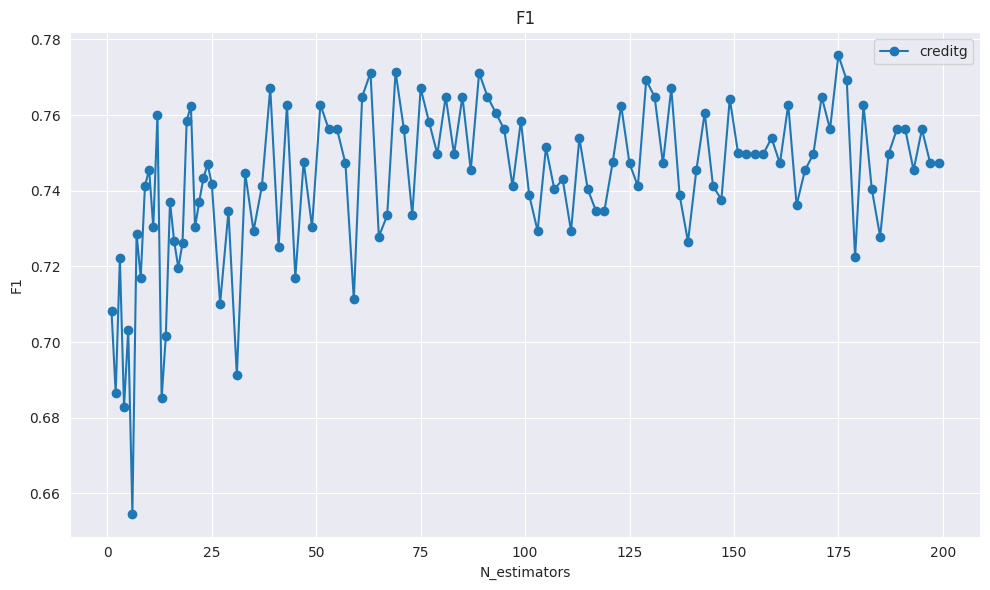

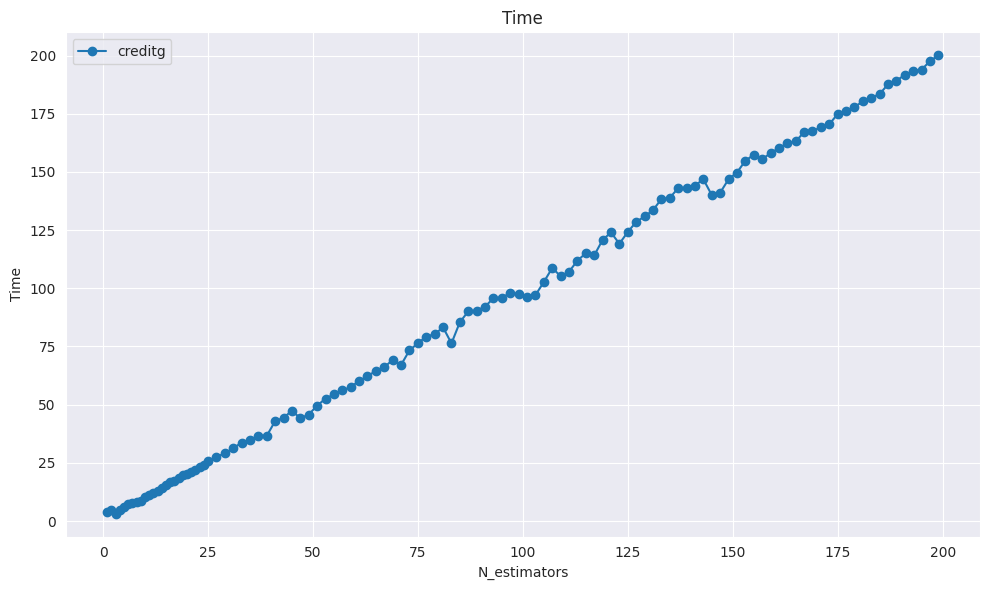

In [98]:
from itertools import chain

hyperparameters = {
    #'n_estimators': 100,
    'criterion': 'gini', # entropy, log_loss
    'verbose': False,
}
hyperparameters_iterator = {'n_estimators': chain(range(1, 25, 1), range(25, 200, 2))}
rf_n_estimators = evaluator.evaluate2(RandomForestClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"creditg": rf_n_estimators}, x_axis='n_estimators', y_axis=['accuracy', 'precision', 'recall', 'f1', 'time'], logaritmic=False)

Evaluating classifier:  RandomForestClassifier
Hyperparameters:  {'n_estimators': 5, 'verbose': False}
Hyperparameter  criterion  value:  gini
Accuracy:  0.705
Recall:  0.705
Precision:  0.6829430379746836
F1:  0.6885595549521507
Time: 5.961418ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  21 |  38 |
|  1 |  21 | 120 |
+----+-----+-----+
Hyperparameter  criterion  value:  entropy
Accuracy:  0.69
Recall:  0.69
Precision:  0.6670819137905497
F1:  0.6740084221608106
Time: 5.826235ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  20 |  39 |
|  1 |  23 | 118 |
+----+-----+-----+
Hyperparameter  criterion  value:  log_loss
Accuracy:  0.73
Recall:  0.73
Precision:  0.7225375433192144
F1:  0.7255803571428572
Time: 5.907059ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  24 | 117 |
+----+-----+-----+
Evaluating classifier:  RandomForestClassifier
Hyperparameters:

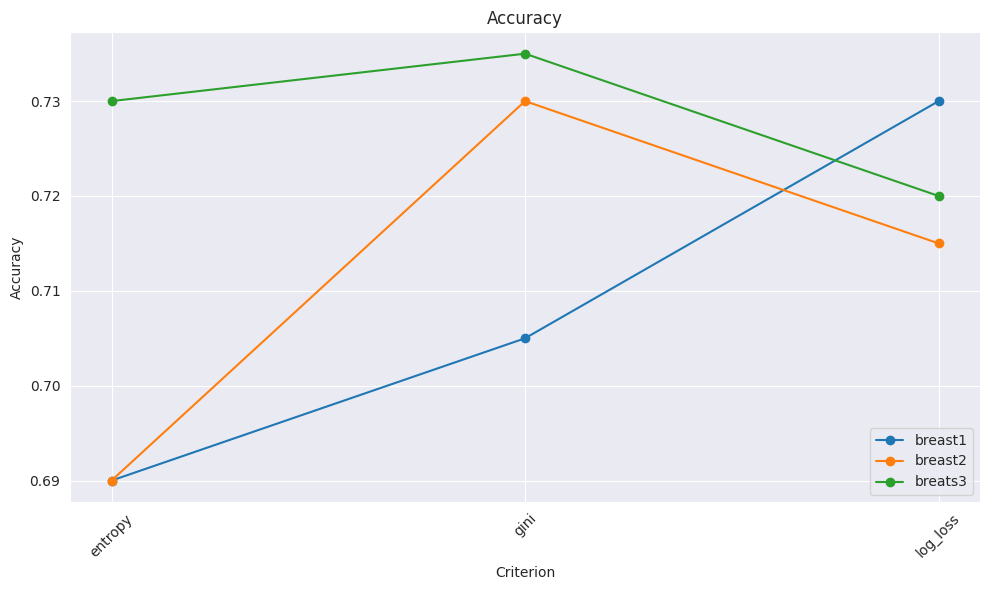

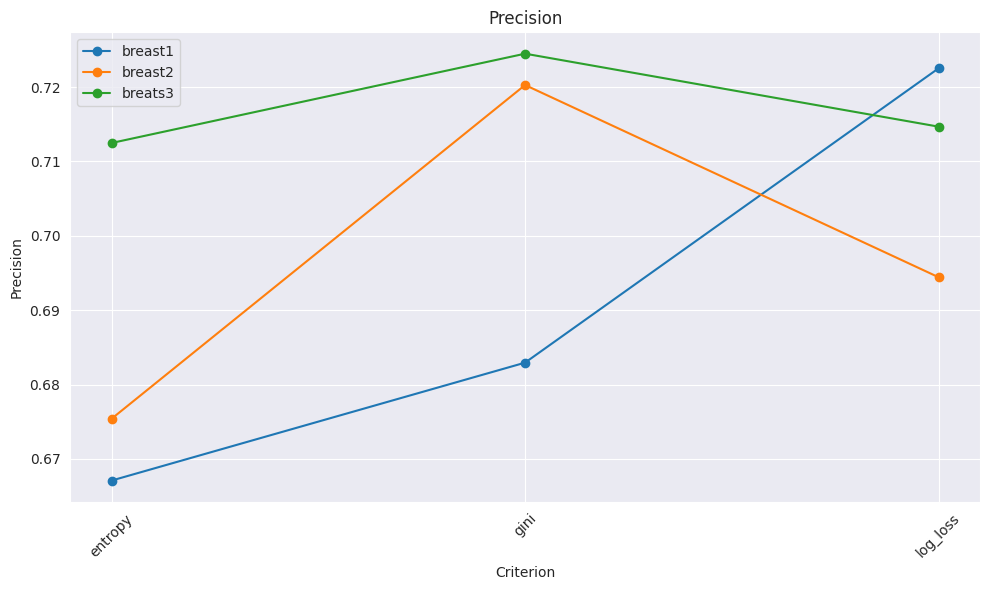

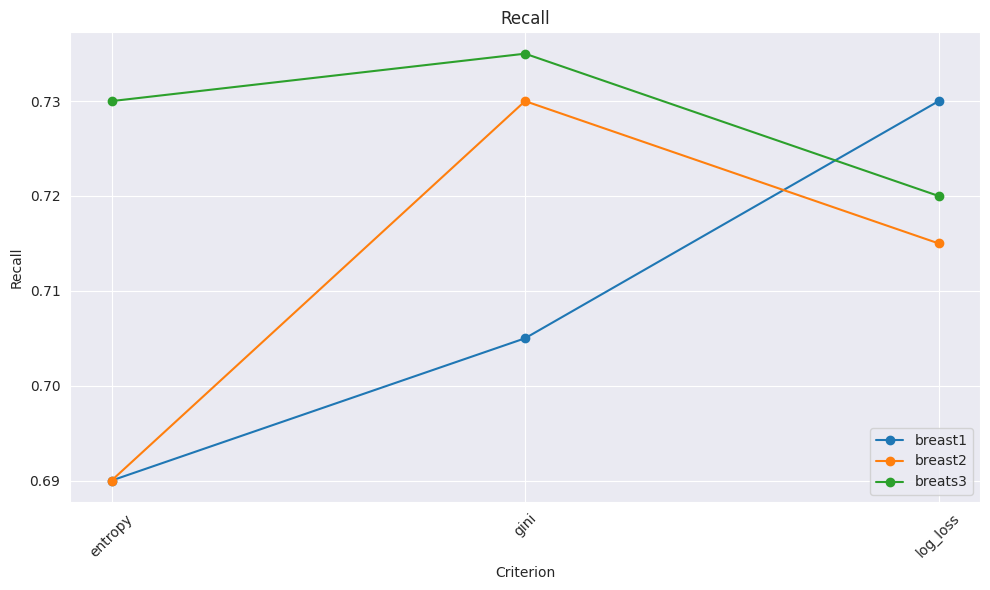

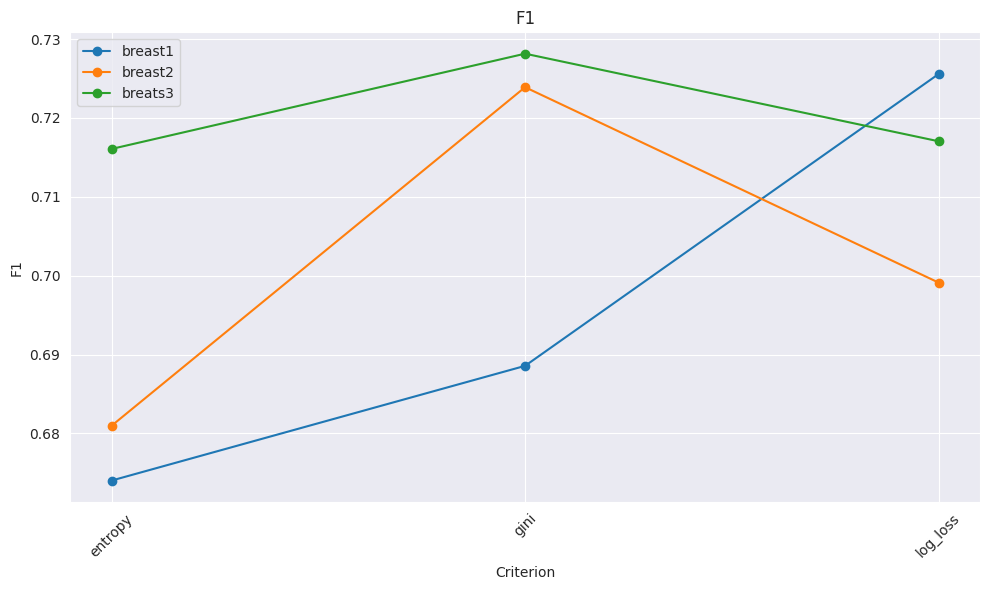

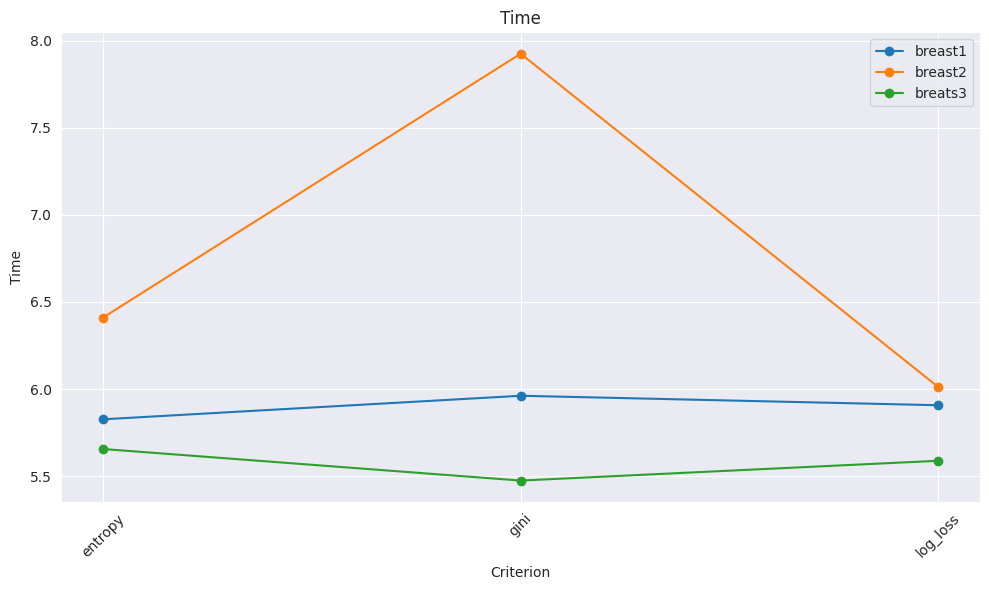

In [99]:
reload(evaluator)
hyperparameters = {
    'n_estimators': 5,
    #'criterion': 'gini', # entropy, log_loss
    'verbose': False,
}
hyperparameters_iterator = {'criterion': ['gini', 'entropy', 'log_loss']}
rf_criterion = evaluator.evaluate2(RandomForestClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
rf_criterion2 = evaluator.evaluate2(RandomForestClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
rf_criterion3 = evaluator.evaluate2(RandomForestClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"breast1": rf_criterion, "breast2": rf_criterion2, "breats3": rf_criterion3}, x_axis='criterion', y_axis=['accuracy', 'precision', 'recall', 'f1', 'time'], logaritmic=False)

## Bayes

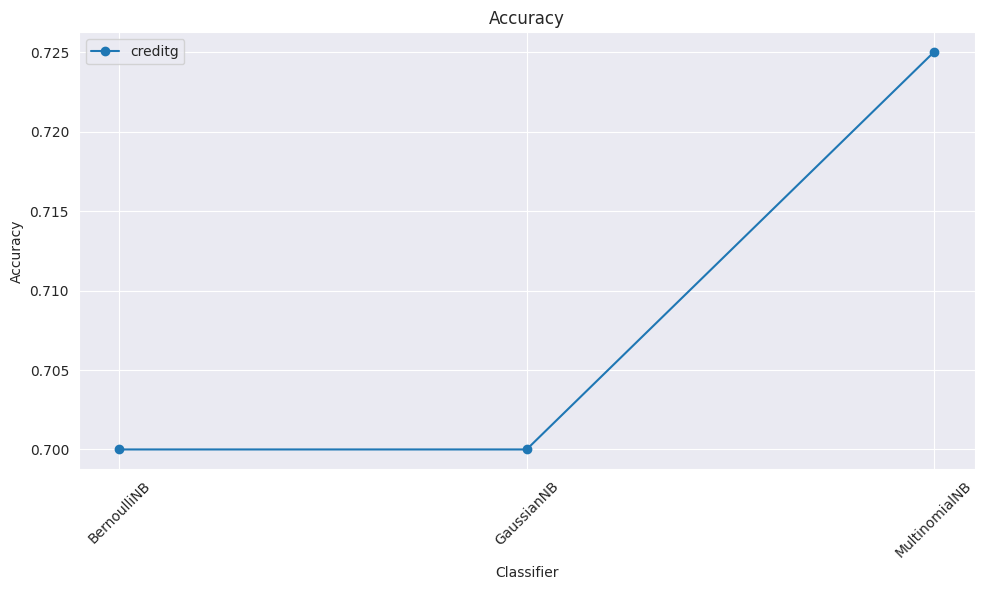

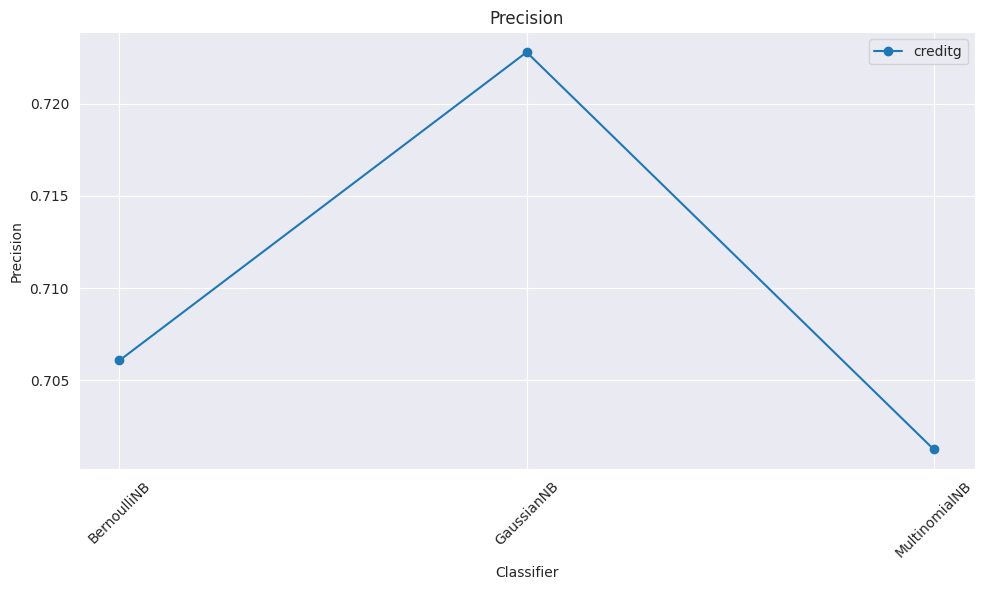

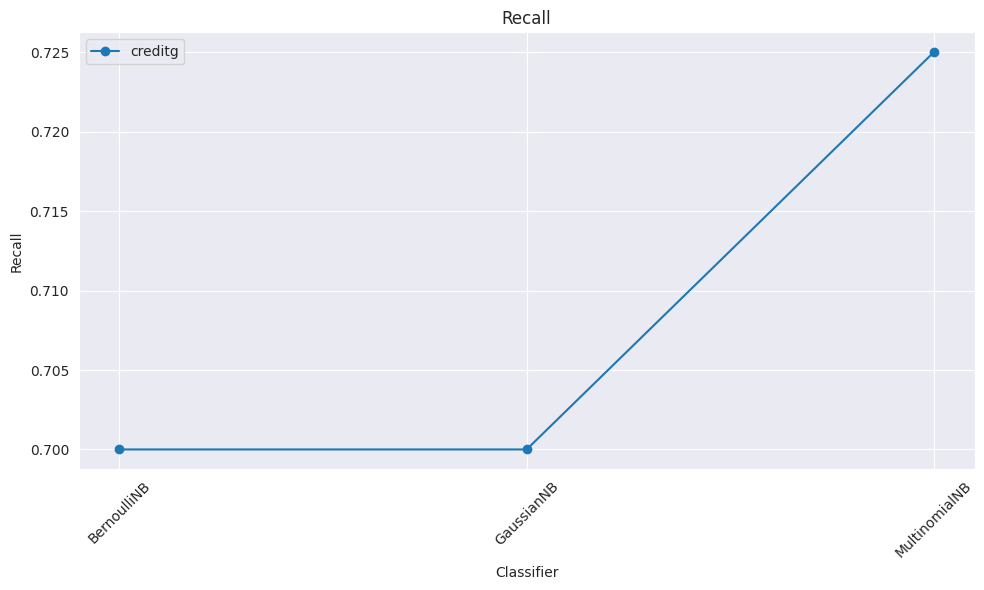

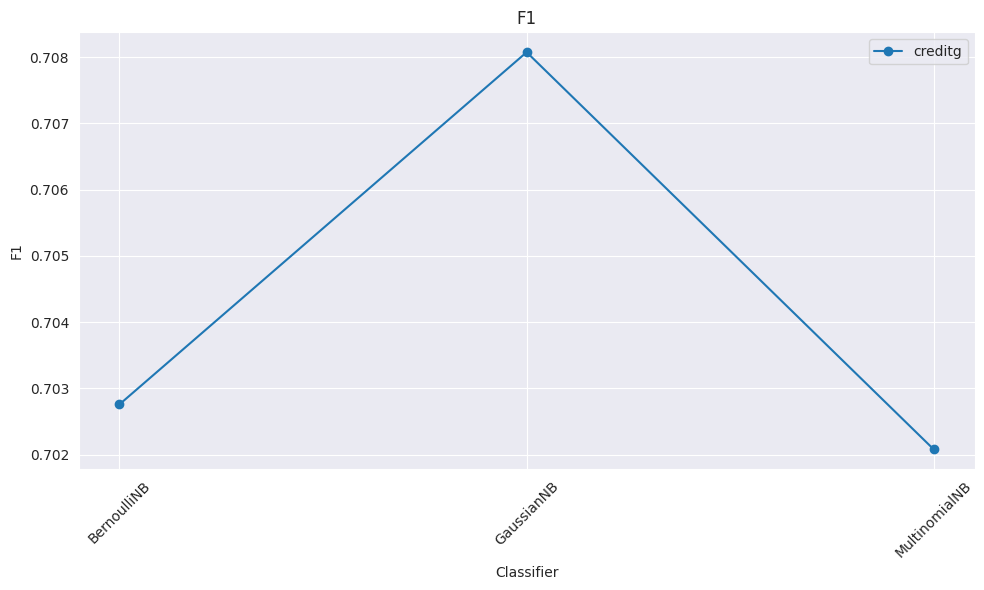

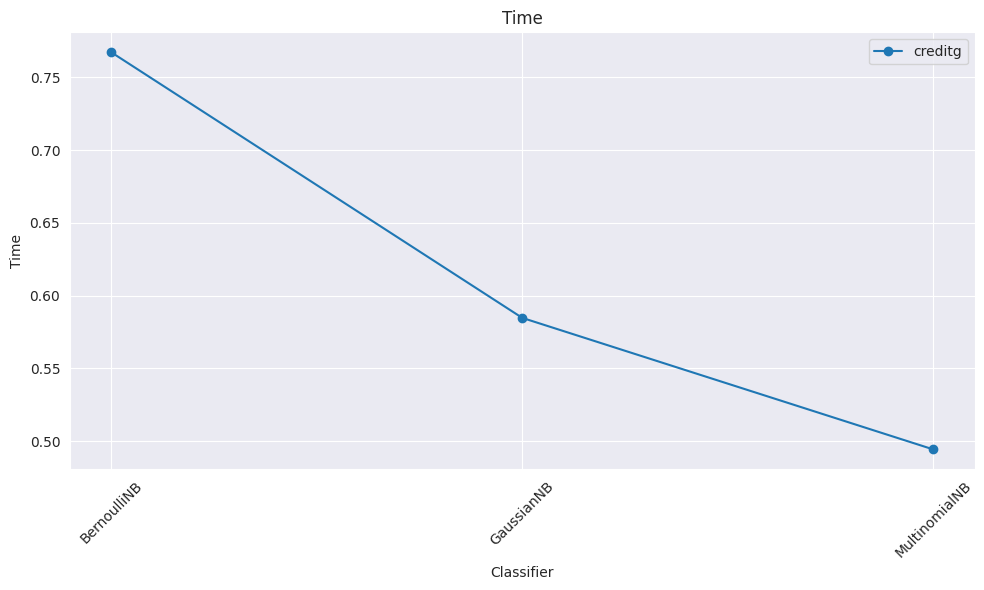

In [28]:
reload(evaluator)

classifiers = [GaussianNB, MultinomialNB, BernoulliNB]
names = ['GaussianNB', 'MultinomialNB', 'BernoulliNB']

bayes_results=evaluator.evaluate_classifier(classifiers, X_train, y_train, X_test, y_test, hyperparameters=[{},{},{},], names=names, number_of_tests=10)
evaluator.draw_diagram2_list({"creditg": bayes_results}, x_axis='classifier', y_axis=['accuracy', 'precision', 'recall', 'f1', 'time'], logaritmic=False)

## evaluate scalers

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (15, 15, 15), 'max_iter': 1000, 'verbose': False}


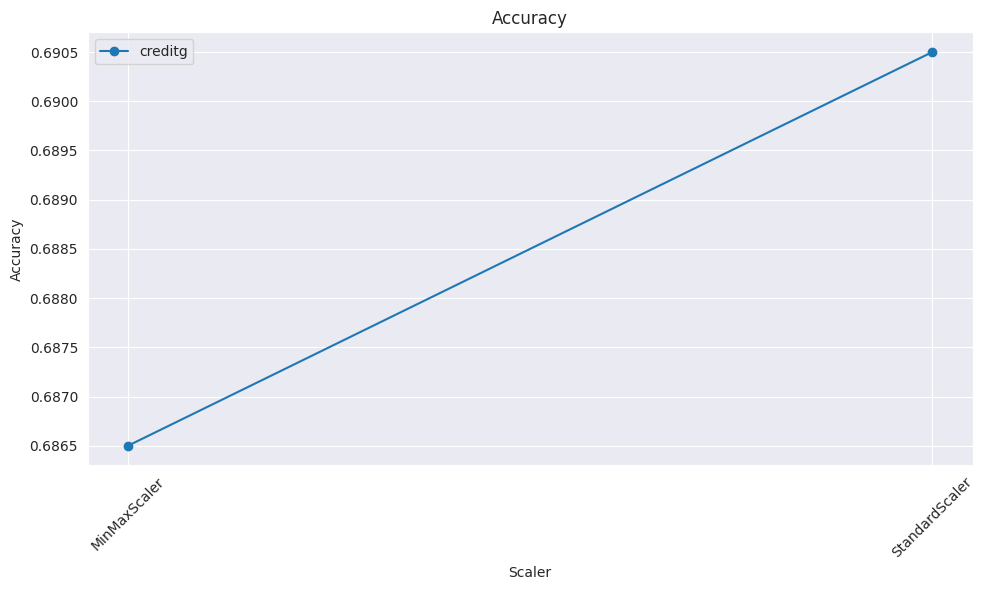

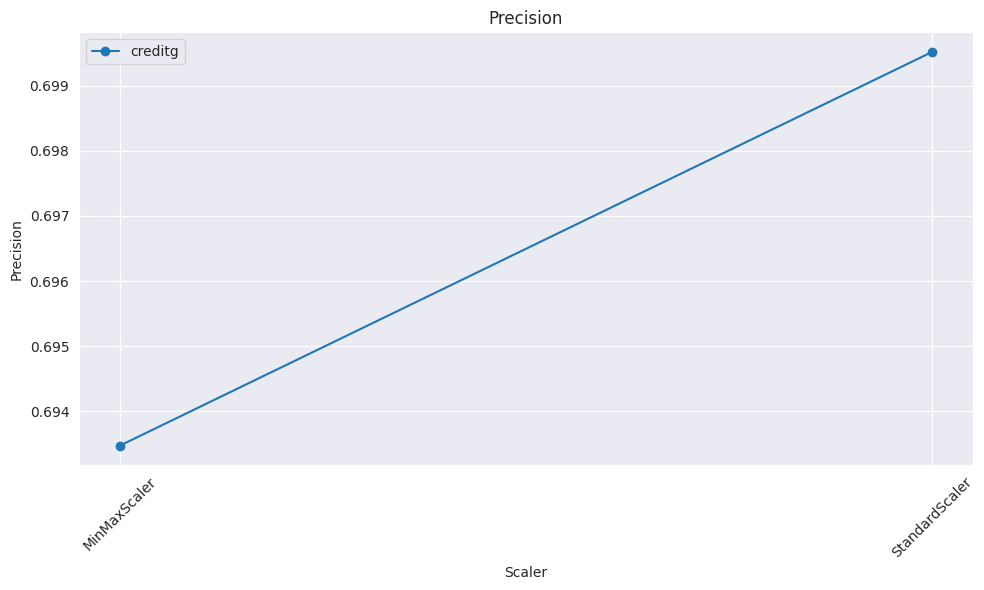

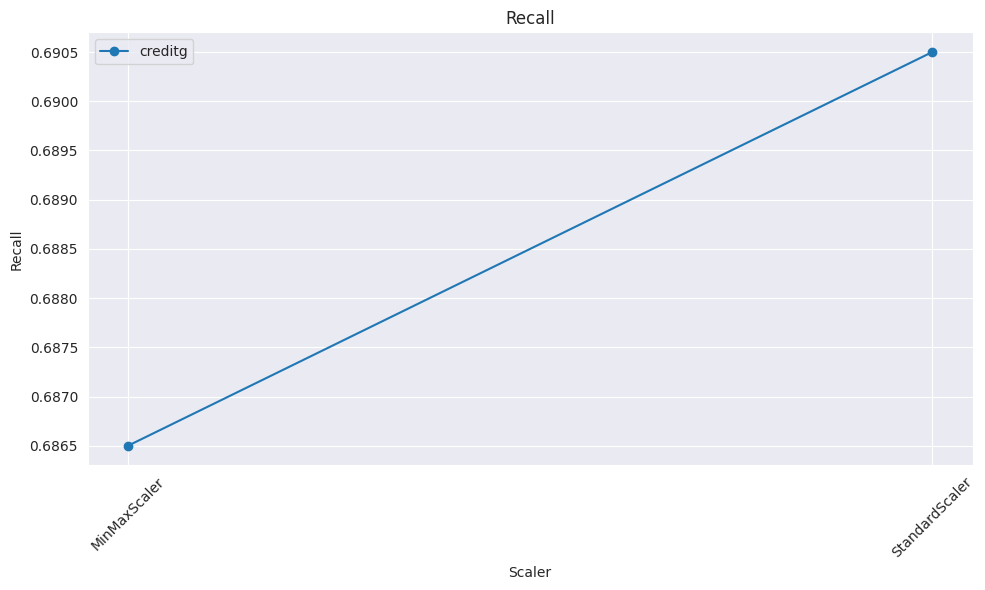

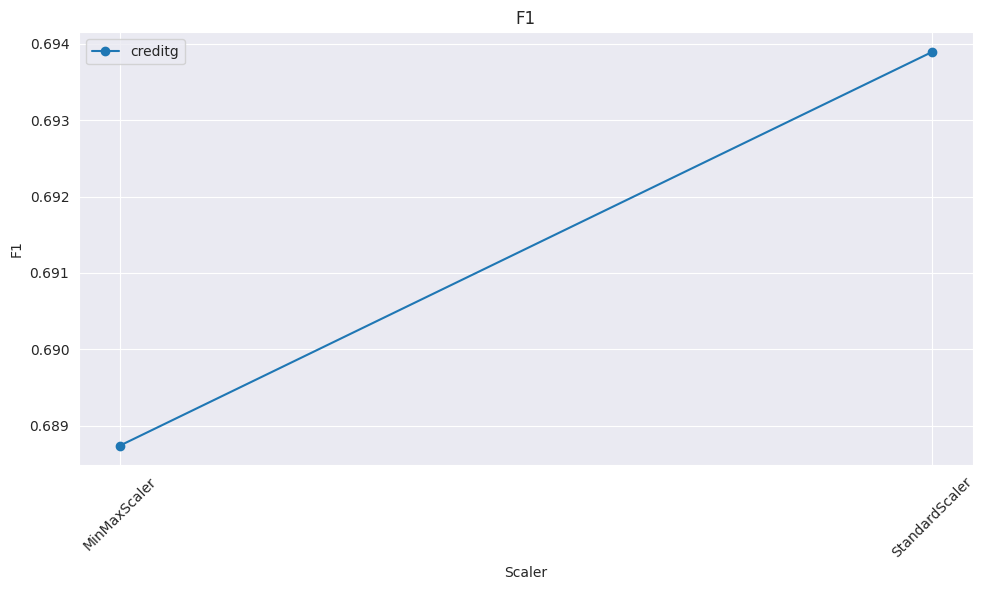

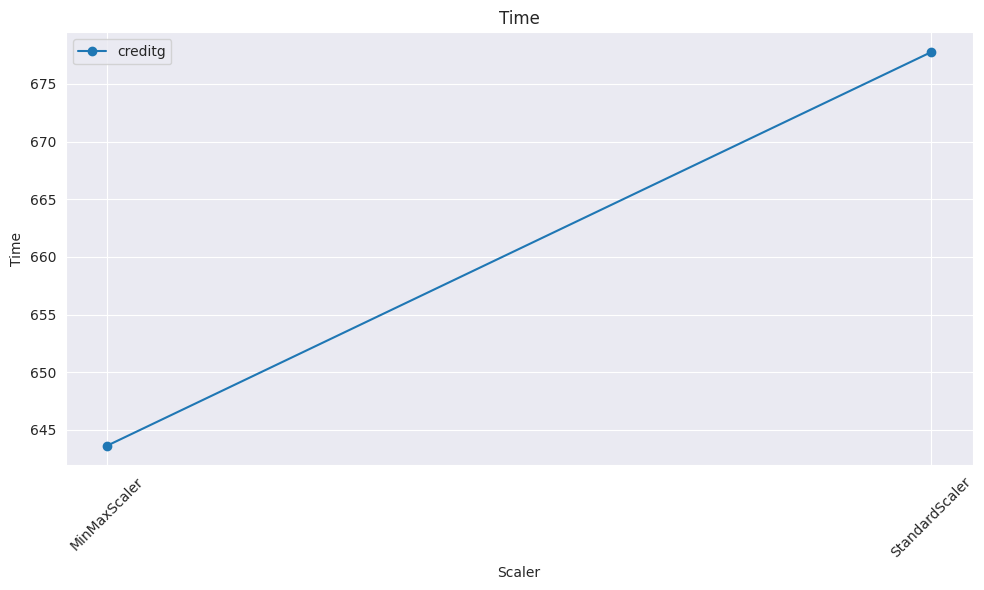

In [27]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    'learning_rate_init': 1e-3,
    'hidden_layer_sizes': (15, 15, 15),
    #'random_state': 7895,
    'max_iter': 1000,
    'verbose': False,
    #'tol': 5e-5
}

scaler_result=evaluator.evaluate_scaler(MLPClassifier, X_train=[X_train, X_train_std], y_train=[y_train, y_train], X_test=[X_test, X_test_std], y_test=[y_test, y_test], hyperparameters=hyperparameters, names=['MinMaxScaler', 'StandardScaler'], number_of_tests=10)
evaluator.draw_diagram2_list({"creditg": scaler_result}, x_axis='scaler', y_axis=['accuracy', 'precision', 'recall', 'f1', 'time'], logaritmic=False)

In [78]:
combined_results_creditg = {
    # NN
    'nn_learning_rate': nn_learning_rate,
    'nn_hidden_layer': nn_hidden_layer,
    'nn_max_iter': nn_max_iter,
    'act_function': act_function1,
    # RF
    'rf_n_estimators': rf_n_estimators,
    'rf_criterion': rf_criterion,
    # Bayes
    'bayes_results': bayes_results,
    'scaler_result': scaler_result
}
import pickle
with open('creditg_results.pkl', 'wb') as f:
    pickle.dump(combined_results_creditg, f)